# Agents: Lab 2

In [2]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

## Flocking behaviour

Agents should both interact with their environment and each other, and change their behaviour to reach some goal (often by maximizing a utility function or similar). One example is a simple model of the behaviour of groups of birds (flocking) or fish (schooling). This *CSA* model says that all individuals only change direction in order to improve

* **Cohesion**: they steer towards the local average location of their flockmates;
* **Separation**: they steer to avoid crowding local flockmates;
* **Alignment**: they steer towards the average heading of their local flockmates.

Here we investigate how this model looks, depending on the initial velocity of the individuals.

In [3]:
%matplotlib inline
import math
from math import atan2
from numpy import cos, sin, pi
import numpy as np
from matplotlib import pyplot, animation
from JSAnimation import IPython_display

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12,6)

import scipy
from scipy.optimize import minimize

from __future__ import division

Define a class called `Agent`. This should store the 2-dimensional ${\bf z} = (x, y)$ location of the individual, and its 2-dimensional velocity ${\bf v} = (v_x, v_y)$. It should have a method that updates its location over a timestep $\Delta t$ as

\begin{equation}
  {\bf z} = \begin{pmatrix} x \\ y \end{pmatrix} \to \begin{pmatrix} x \\ y \end{pmatrix} + \Delta t \begin{pmatrix} v_x \\ v_y \end{pmatrix} = {\bf z} + \Delta t \, {\bf v}.
\end{equation}

The `Agent` should also have a method that changes its velocity to maximize its "CSA utility": given a list of other agents that are the "local flockmates", it should choose its heading to maximize cohesion, separation and alignment. The CSA utility is a function of the locations and velocities that returns a single number, and is to be maximized by varying the direction of the velocity of this `Agent`.

As an example, define the following utility function:

\begin{equation}
  f \left( {\bf v} ; {\bf z}, {\bf z}_i, {\bf v}_i \right) = C \frac{{\bf v} \cdot \Delta {\bf z}}{ \| {\bf v} \| \| \Delta {\bf z} \| } + A \frac{{\bf v} \cdot {\bf V}}{ \| {\bf v} \| \| {\bf V} \| } - S \frac{{\bf v} \cdot \Delta {\bf z}_{\text{min}}}{ \| {\bf v} \| \| \Delta {\bf z}_{\text{min}} \|^3 }.
\end{equation}

$f$ is the utility function itself. It depends on the velocity ${\bf v}$ of the current `Agent`, which can be varied. It also depends on the location ${\bf z}$ of the current `Agent`, as well as the locations ${\bf z}_i$ and velocities ${\bf v}_i$ of the local flockmates, which cannot be varied.

The coefficients $C, S, A$ give the relative importance of improving the cohesion, separation, and alignment respectively.

$\Delta {\bf z}$ is the *average location difference* between the current `Agent` position ${\bf z}$ and the position of its local flockmates ${\bf z}_i$, given by

\begin{equation}
  \Delta {\bf z} = \frac{1}{N} \sum_{i=1}^{N} \begin{pmatrix} x_i - x \\ y_i - y \end{pmatrix}
\end{equation}

${\bf V}$ is the *average velocity* of the local flockmates, given by

\begin{equation}
  {\bf V} = \frac{1}{N} \sum_{i=1}^{N} \begin{pmatrix} (v_x)_i \\ (v_y)_i \end{pmatrix}.
\end{equation}

$\Delta {\bf z}_{\text{min}}$ is the location of the flockmate that is closest to the current `Agent`. Note that the norm of this difference in the denominator is cubed, to ensure that when two agents get close together they are strongly repelled.

**Note**: it is only the *direction* of the velocity ${\bf v}$ that matters in this function. We can define a set of magnitudes and angles:

\begin{align}
  {\bf v} &= v \left( \cos(\theta) \hat{\bf i} + \sin(\theta) \hat{\bf j} \right), \\
  \Delta {\bf z} &= \Delta z \left( \cos(\theta_z) \hat{\bf i} + \cos(\theta_z) \hat{\bf j} \right), \\
  {\bf V} &= V \left( \cos(\theta_V) \hat{\bf i} + \cos(\theta_V) \hat{\bf j} \right), \\
  \Delta {\bf z}_{\text{min}} &= \Delta z_{\text{min}} \left( \cos(\theta_{z_{\text{min}}}) \hat{\bf i} + \cos(\theta_{z_{\text{min}}}) \hat{\bf j} \right).
\end{align}

We can then write

\begin{equation}
  f \left( \theta ; {\bf z}, {\bf z}_i, {\bf v}_i \right) = C \cos(\theta - \theta_z) + A \cos(\theta - \theta_V) - S \frac{\cos(\theta - \theta_{z_{\text{min}}})}{\Delta z_{\text{min}}^2 }.
\end{equation}

To start, use values for the parameters of

\begin{align}
  C &= 1, \\ A &=5, \\ S &= 0.1.
\end{align}

In [4]:
class Agent(object):
    
    def __init__(self, location, velocity, C=1, A=5, S=0.1):
        self.loc = np.array(location)
        self.v = np.array(velocity)
        self.C = C
        self.A = A
        self.S = S
    
    def step(self, dt): 
        self.loc += self.v*dt
        
    def steer(self, neighbours):
        N = len(neighbours)
        if N == 0:
            return
        min_sep = 100.0
        # Initialise vectors
        diff_avg_loc = np.zeros_like(self.loc)
        min_sep_direction = diff_avg_loc.copy()
        avg_v = diff_avg_loc.copy()
        for ag in neighbours:
            diff_avg_loc += ag.loc - self.loc
            avg_v += ag.v
            sep = np.linalg.norm(ag.loc - self.loc)
            if sep < min_sep:
                min_sep = sep
                min_sep_direction = ag.loc - self.loc
        avg_v /= N
        diff_avg_loc /= N
        v = np.linalg.norm(self.v)
        # Compute theta values
        th = atan2(self.v[1], self.v[0])
        th_z = atan2(diff_avg_loc[1], diff_avg_loc[0])
        th_V = atan2(avg_v[1], avg_v[0])
        th_min_z = atan2(min_sep_direction[1], min_sep_direction[0])
        minz = np.linalg.norm(min_sep_direction)
        
        C = self.C
        A = self.A
        S = self.S
        
        utility = lambda theta: -(C * cos(theta - th_z)+\
                                A * cos(theta - th_V)-\
                                S * cos(theta - th_min_z) / minz**2)
        res = minimize(utility, th, bounds=[[-pi, pi]])
        th_new = res.x[0]
        self.v = np.array([v * cos(th_new), v * sin(th_new)])

Test that the `Agent` steers as expected given a list of zero or one local flockmates.

In [5]:
# No neighbours
a0 = Agent([0.0, 0.0], [0.0, 1.0])
a0.steer([])
print(a0.loc, a0.v)
# Time step
a0.step(0.1)
print(a0.loc, a0.v)
# One neighbour, far away
a1 = Agent([-1.0, 0.0], [0.0, 1.0])
a2 = Agent([ 1.0, 0.0], [0.0, 1.0])
a1.steer([a2])
print("One neighbour, separation 2")
print(a1.loc, a1.v)
print(np.linalg.norm(a1.v))
print("\n")

# One neigbour, moving very fast
a1 = Agent([-1.0, 0.0], [0.0, 1.0])
a3 = Agent([1.0, 0.0], [0.0, 1000.0])
a1.steer([a3])
print("One neighbour, moving fast")
print(a1.loc, a1.v)
print(np.linalg.norm(a1.v))
print("\n")

# One neighbour, far too close
a1 = Agent([-1.0, 0.0], [0.0, 1.0])
a4 = Agent([-1.0+0.001, 0.0], [0.0, 1.0])
a1.steer([a4])
print("One neighbour, too close")
print(a1.loc, a1.v)
print(np.linalg.norm(a1.v))
print("\n")

[ 0.  0.] [ 0.  1.]
[ 0.   0.1] [ 0.  1.]
One neighbour, separation 2
[-1.  0.] [ 0.19139507  0.98151308]
1.0


One neighbour, moving fast
[-1.  0.] [ 0.19139507  0.98151308]
1.0


One neighbour, too close
[-1.  0.] [ -9.99999997e-01   7.85372733e-05]
1.0




Now define a `Flock` class containing a list of `Agents`. The flock should be initialized from appropriate `numpy` arrays and values for the locality radius $r_l$, which should default to `1`. The flock should be able to compute and return

* the positions of all its members
* the average location of all its members
* the average velocity, or heading, of all its members
* the average distance from the average location.

Test, with flocks of one, two, and three agents, that it behaves as you expect. Timesteps of order $0.1$ for velocities of order $1$ are reasonable.

In [6]:
class Flock(object):
    def __init__(self, locations, velocities, rl=1):
        self.rl = rl
        self.agents = []
        for loc, vel in zip(locations, velocities):
            self.agents.append(Agent(loc, vel))
    
    def step(self, dt):
        for i, agent in enumerate(self.agents):
            index = np.logical_and(np.linalg.norm(self.locations(i) - np.array([agent.loc]).T,
                                   axis=0) < self.rl, np.logical_not(np.array(self.agents) == agent))
            agent.steer(np.array(self.agents)[index])
        for agent in self.agents:
            agent.step(dt)
    
    def locations(self, i=None):
        x = np.zeros(len(self.agents))
        y = x.copy()
        for j, agent in enumerate(self.agents):
            if not i == j:
                x[j], y[j] = agent.loc
        return np.vstack((x, y))
    
    def velocities(self):
        vx = np.zeros(len(self.agents))
        vy = vx.copy()
        for i, agent in enumerate(self.agents):
            vx[i], vy[i] = agent.v
        return np.vstack((vx, vy))
    
    def average_location(self):
        return np.mean(self.locations(), axis=1)
    
    def average_velocity(self):
        return np.mean(self.velocities(), axis=1)
    
    def average_width(self):
        locs = self.locations()
        average_loc = self.average_location()
        distances = np.linalg.norm(locs-average_loc[:,np.newaxis], axis=0)
        return np.mean(distances)

In [7]:
locations = np.array([[0.0, 0.0], [0.25, 0.25], [0.125, 0.125]])
velocities = np.ones_like(locations)
flock = Flock(locations, velocities)

Create a flock of $50$ agents randomly distributed within $[0, 5]^2$. Give them initial velocities of $(1, 1) + 10^{-2} {\bf v}_r$, where ${\bf v}_r$ is a random velocity with each component a uniform random number in $[0, 1]$.

Evolve the flock using timesteps of $0.05$ for $200$ steps and plot the flock behaviour. Also plot the "width" of the flock (the average distance from the average location), and the average location and heading with time.

In [8]:
def flock_animation(flock, dt, frames=10, xlim=(-0.1, 5), ylim=(-0.1, 5)):
    # First evolve
    
    locations = [flock.locations()]
    ave_width = [flock.average_width()]
    ave_loc = [flock.average_location()]
    ave_vel = [flock.average_velocity()]
    times = np.arange(0.0, frames*dt, dt)
    for i in range(frames):
        flock.step(dt)
        locations.append(flock.locations())
        ave_width.append(flock.average_width())
        ave_loc.append(flock.average_location())
        ave_vel.append(flock.average_velocity())
        
    max_width = max(ave_width)
    min_width = min(ave_width)
    d_width = max_width - min_width
    
    fig = pyplot.figure()
    ax1 = fig.add_subplot(131)
    ax1.set_xlim(xlim[0], xlim[1])
    ax1.set_ylim(ylim[0], ylim[1])
    points, = ax1.plot([], [], 'ro')
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$y$")
    ax2 = fig.add_subplot(132)
    width, = ax2.plot([], [], 'b-')
    ax2.set_xlabel("$t$")
    ax2.set_ylabel("Average width of flock")
    ax2.set_xlim(0.0, dt*frames)
    ax2.set_ylim(min_width-0.1*d_width, max_width+0.1*d_width)
    ax3 = fig.add_subplot(133)
    loc, = ax3.plot([], [], 'bo', label='Location')
    vel, = ax3.plot([], [], 'r*', label='Heading')
    ax3.set_xlabel("$x$")
    ax3.set_ylabel("$y$")
    ax3.set_xlim(xlim[0], xlim[1])
    ax3.set_ylim(ylim[0], ylim[1])
    ax3.legend()
    fig.tight_layout()

    def init():
        points.set_data([], [])
        width.set_data([], [])
        loc.set_data([], [])
        vel.set_data([], [])
        return (points, width, loc, vel)

    def animate(i):
        points.set_data(locations[i][0,:], locations[i][1,:])
        width.set_data(times[:i+1], ave_width[:i+1])
        loc.set_data([ave_loc[i][0]], [ave_loc[i][1]])
        vel.set_data([ave_vel[i][0]], [ave_vel[i][1]])
        return (points, width, loc, vel)

    return animation.FuncAnimation(fig, animate, init_func=init, interval=100, frames=frames, blit=True)

In [9]:
nbirds = 50
locations = 5.0*np.random.rand(nbirds,2)
velocities = np.ones_like(locations) + 0.01*np.random.rand(nbirds,2)
flock = Flock(locations, velocities)


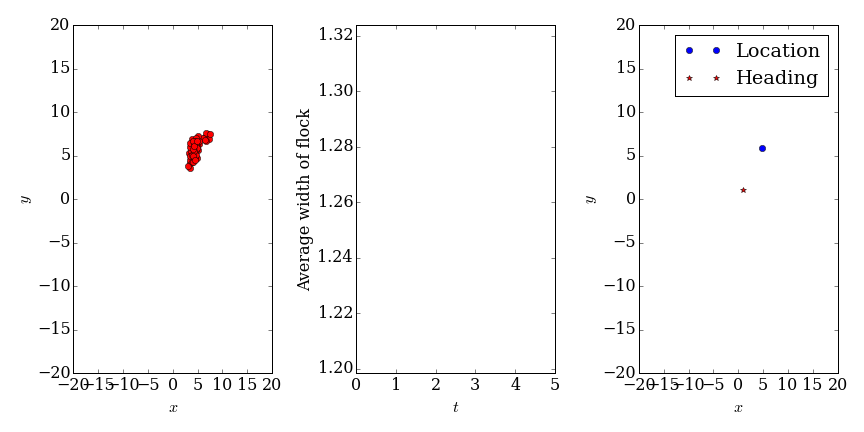
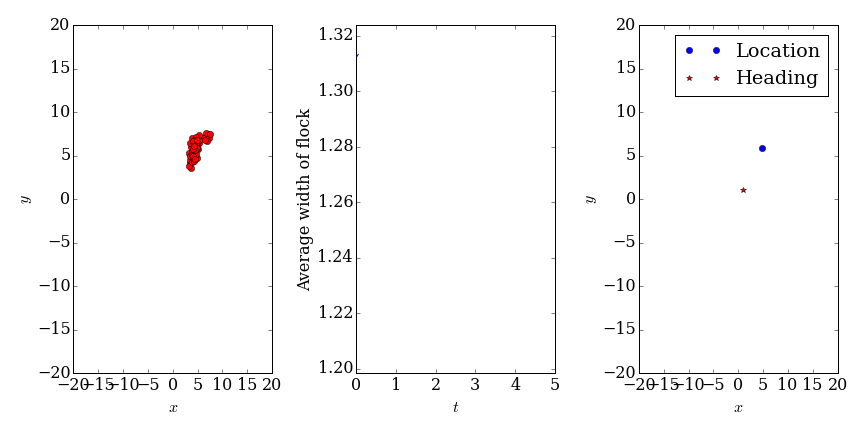
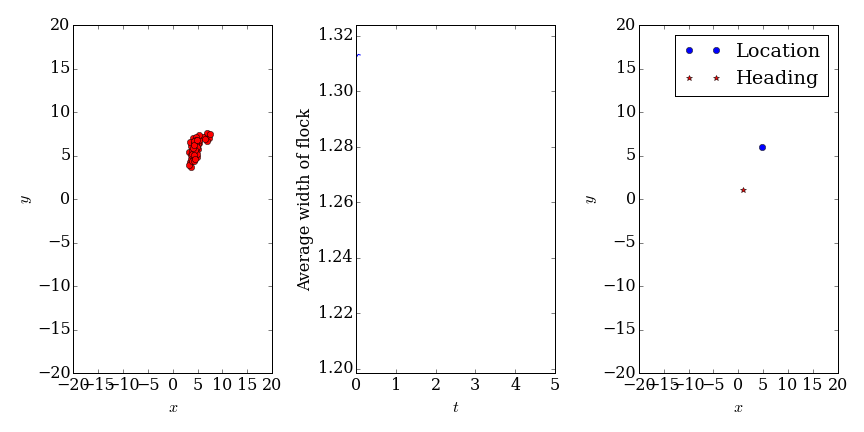
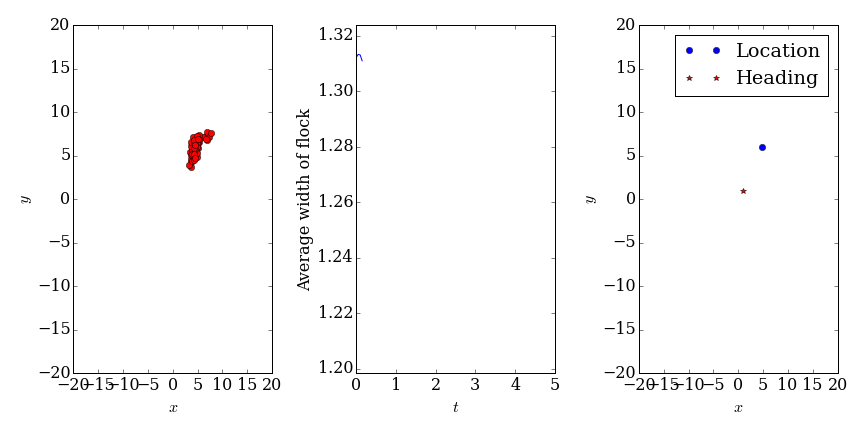
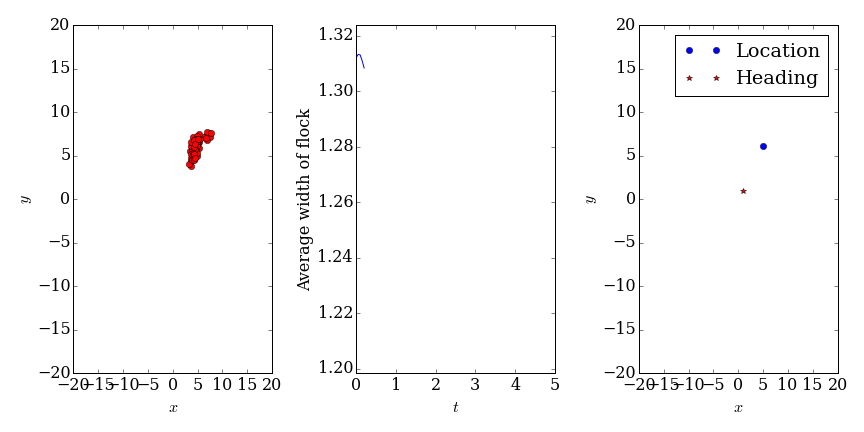
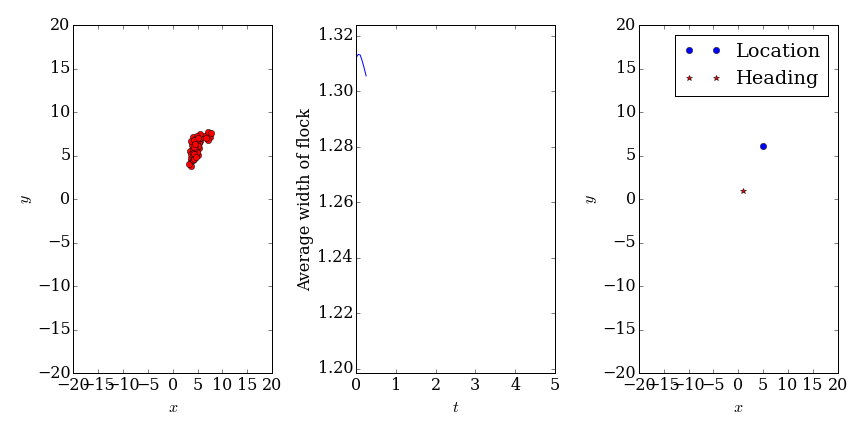
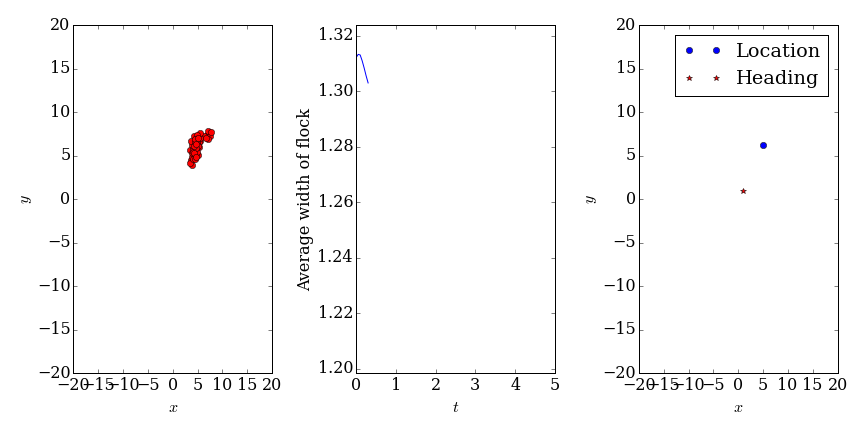
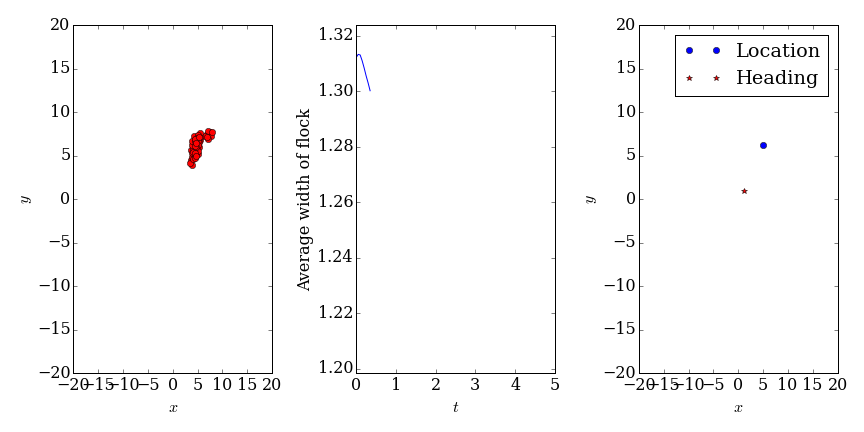
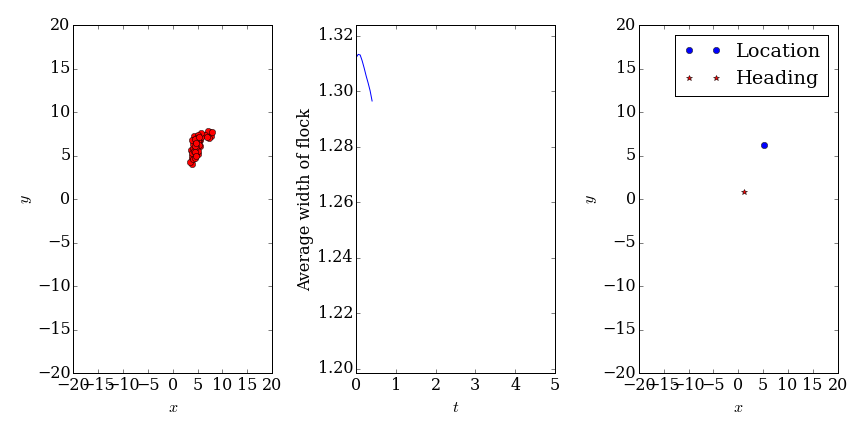
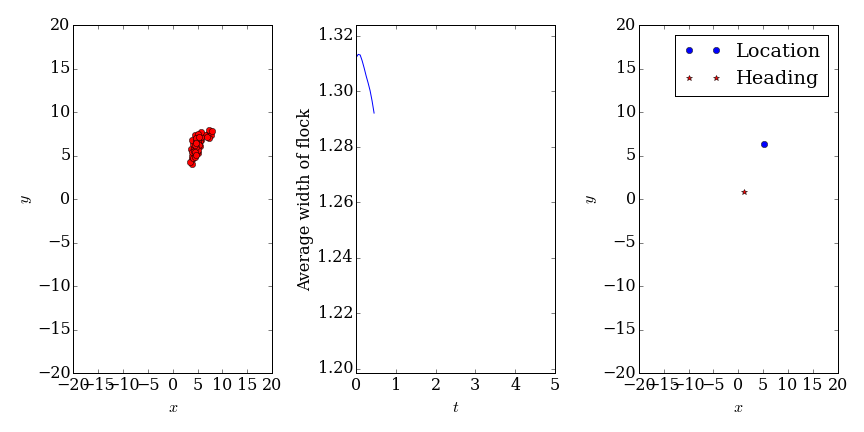
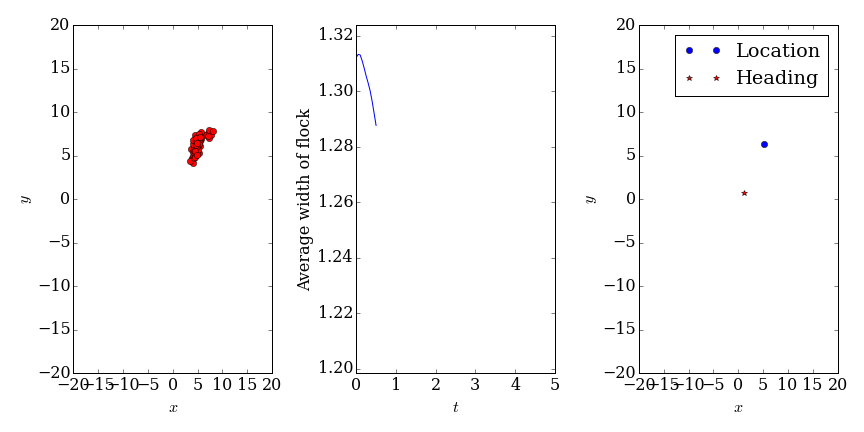
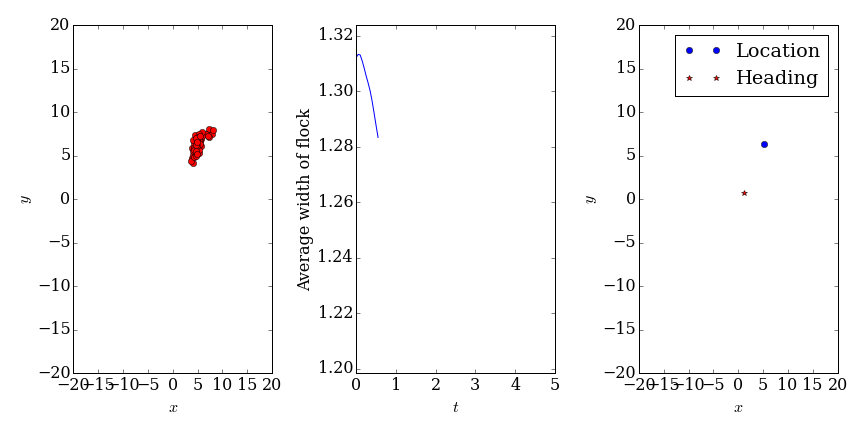
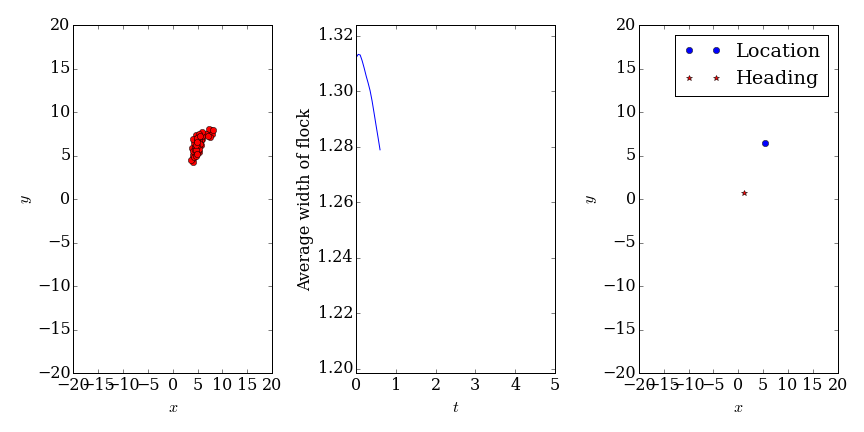
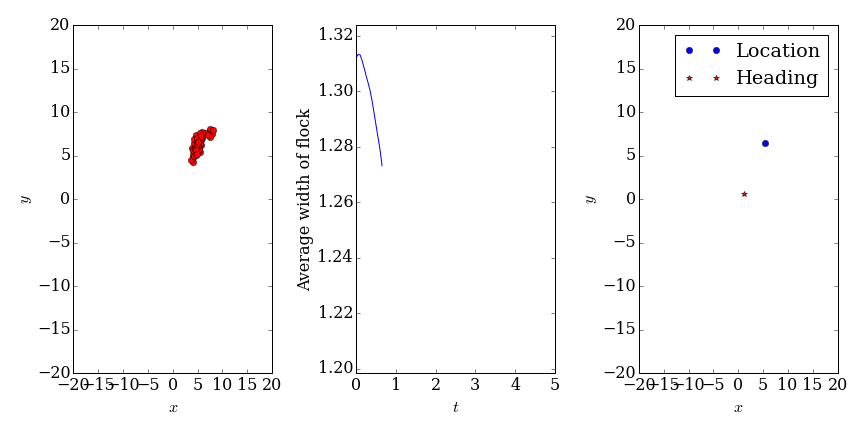
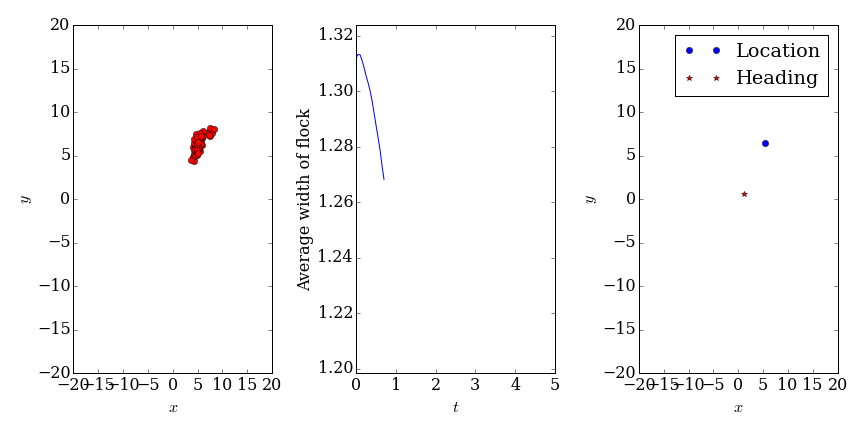
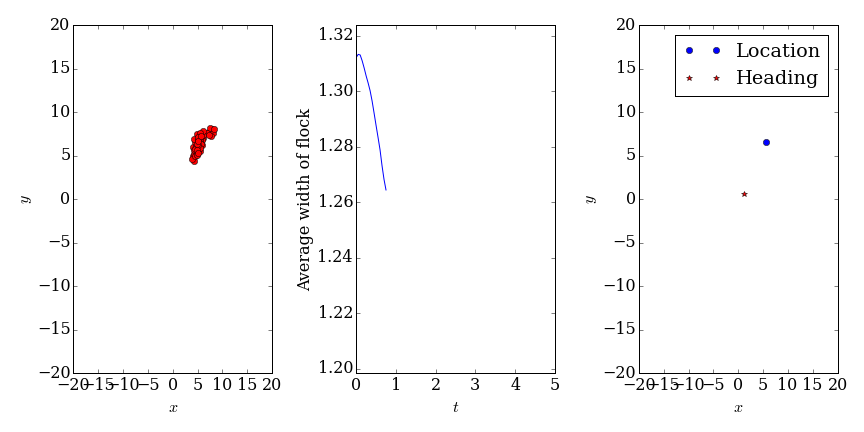
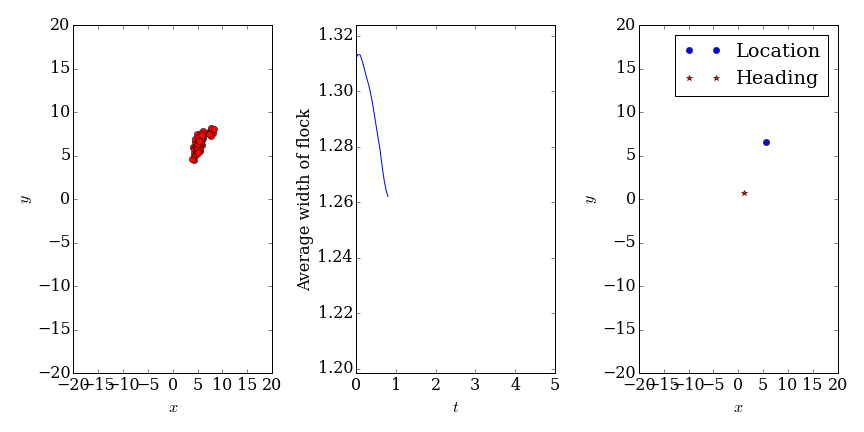
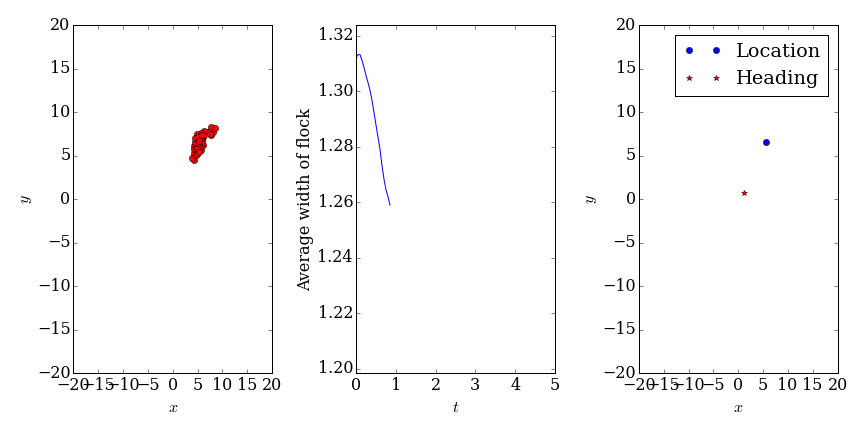
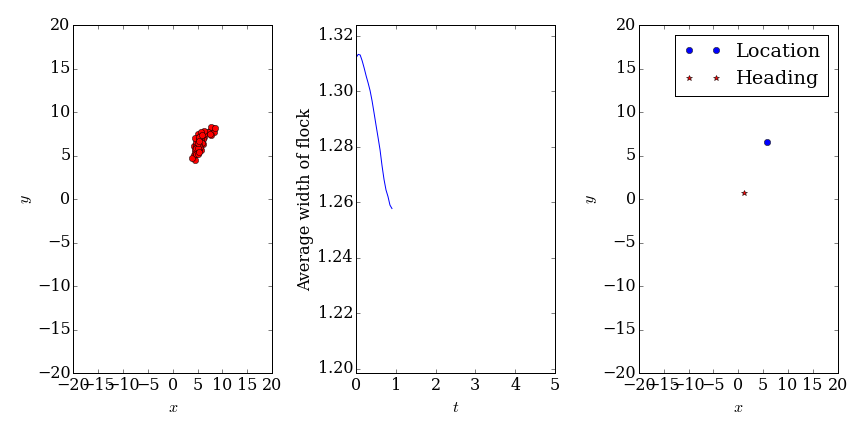
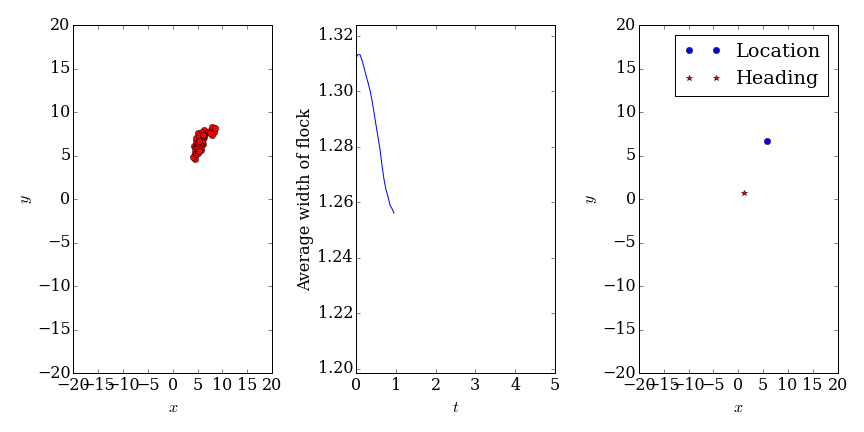
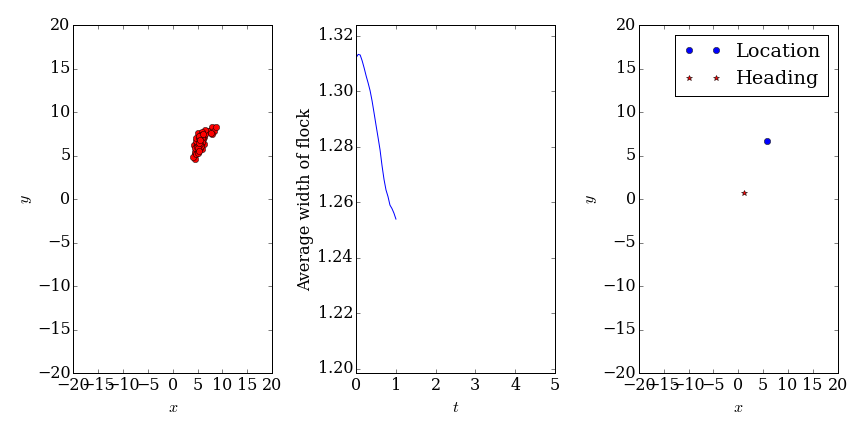
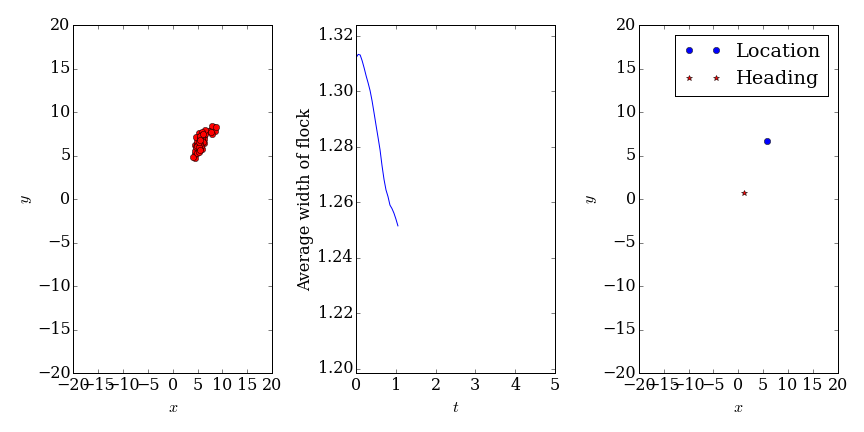
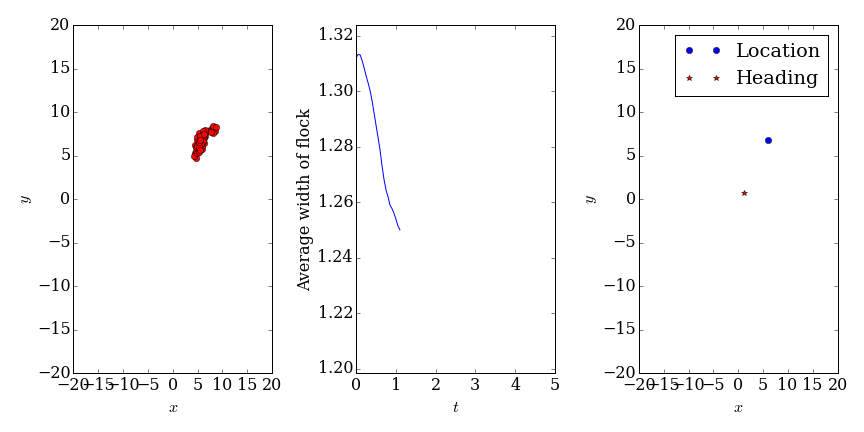
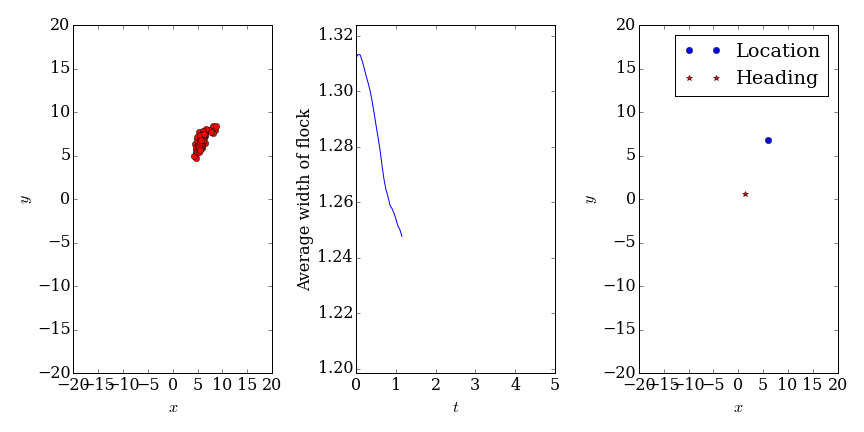
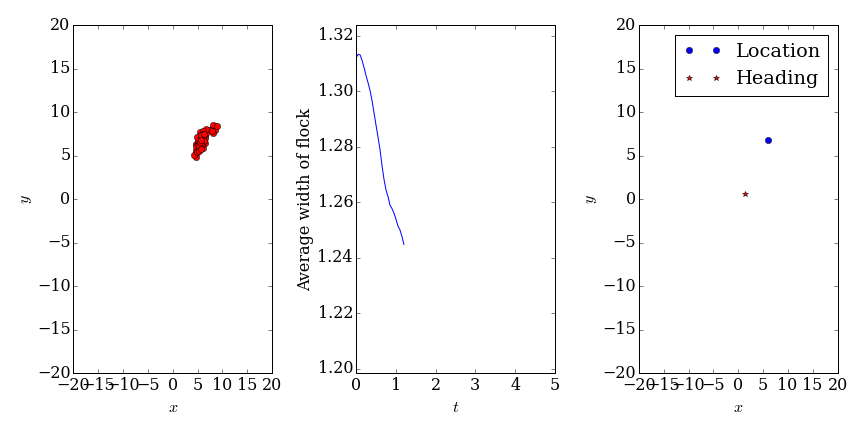
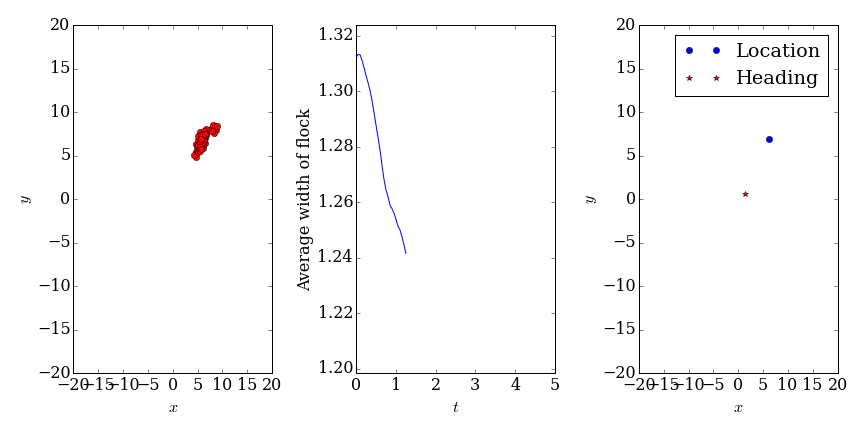
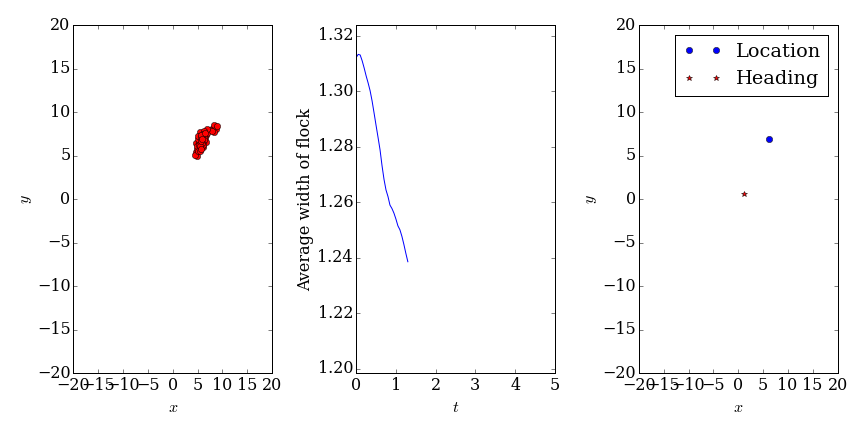
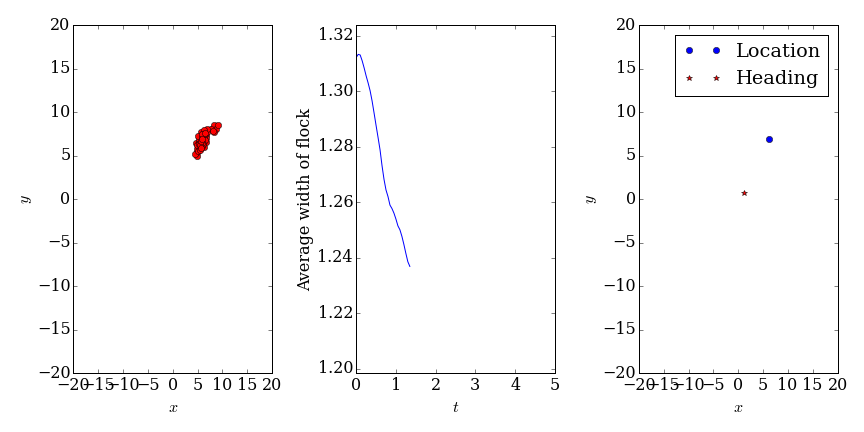
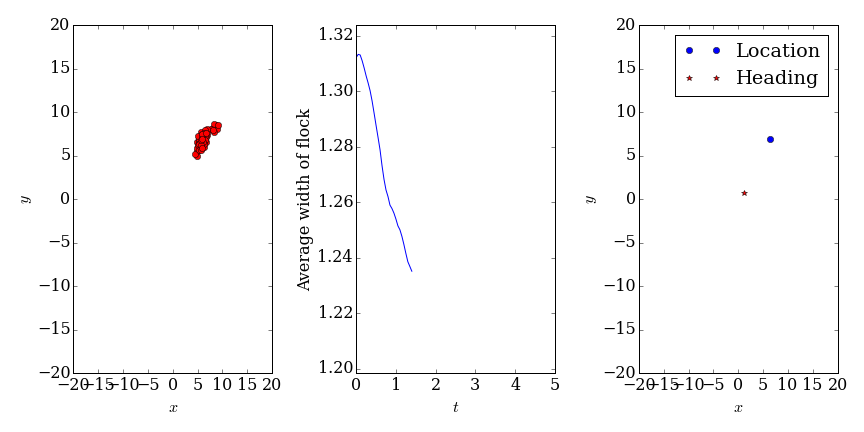
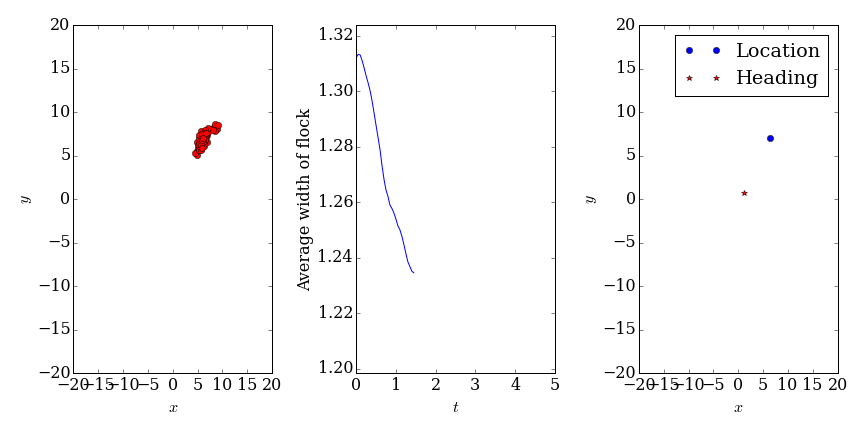
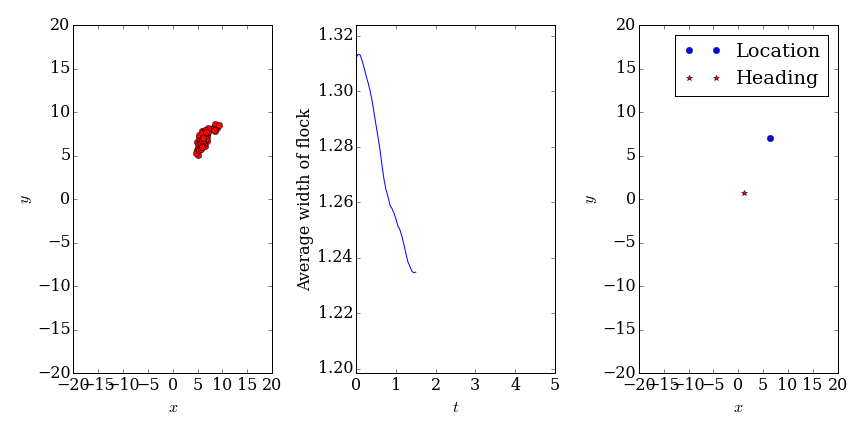
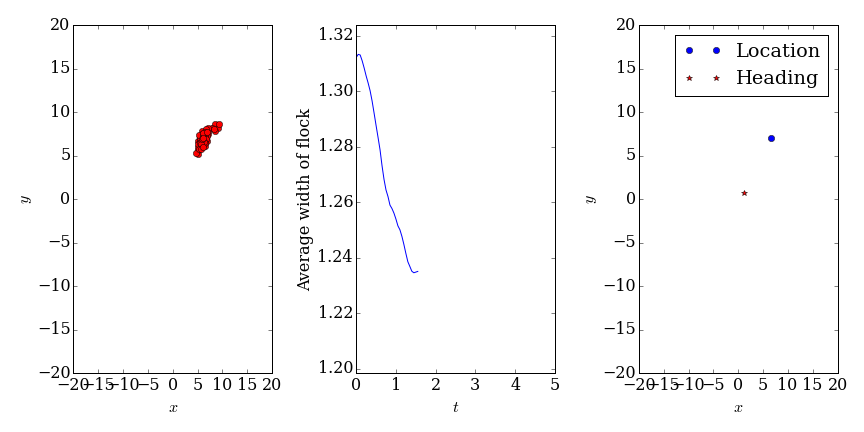
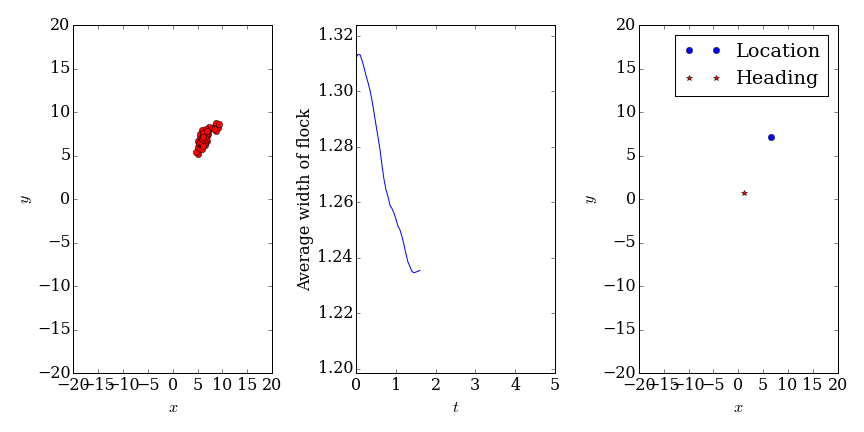
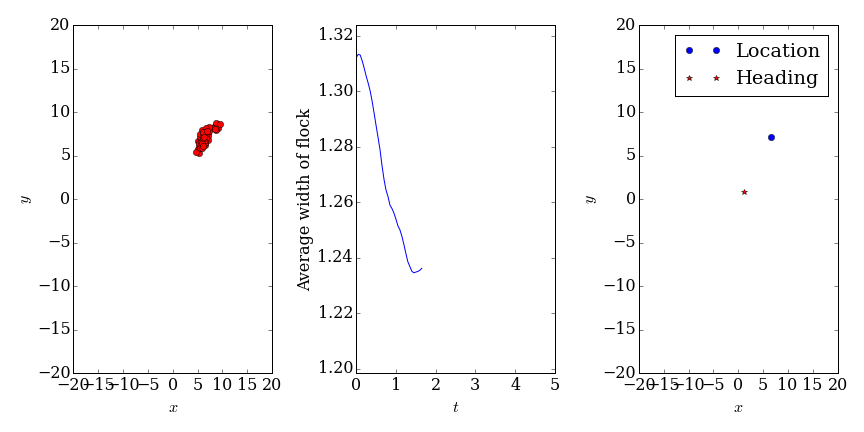
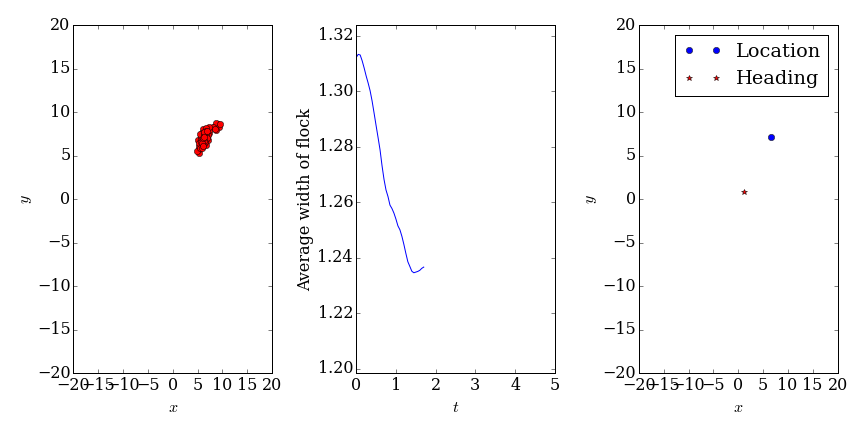
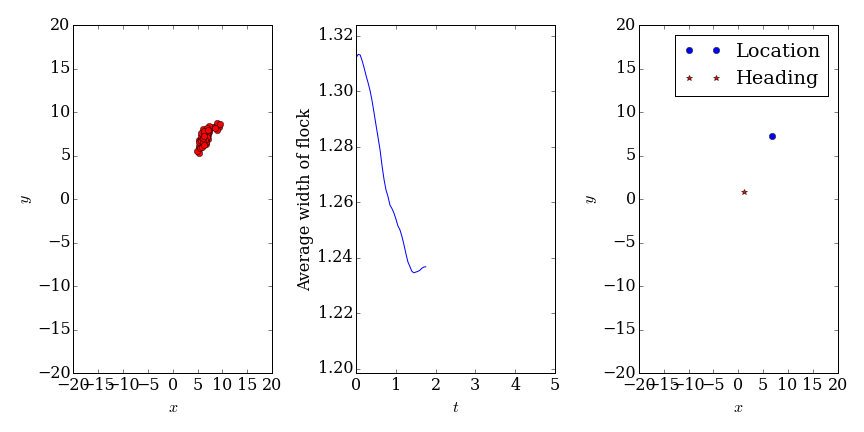
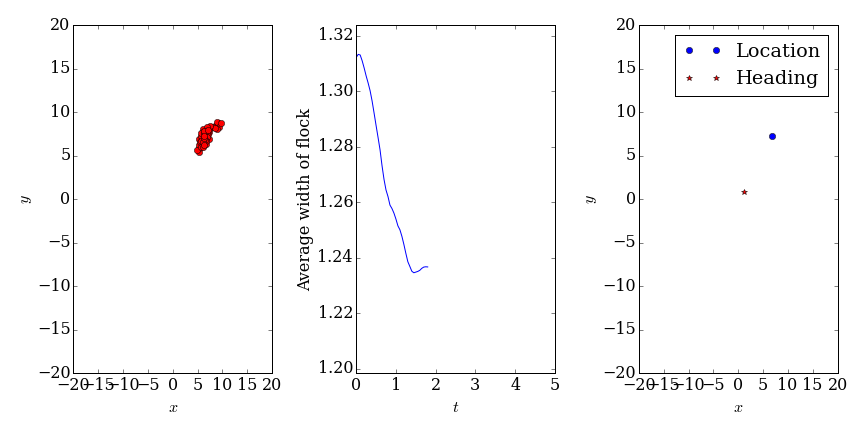
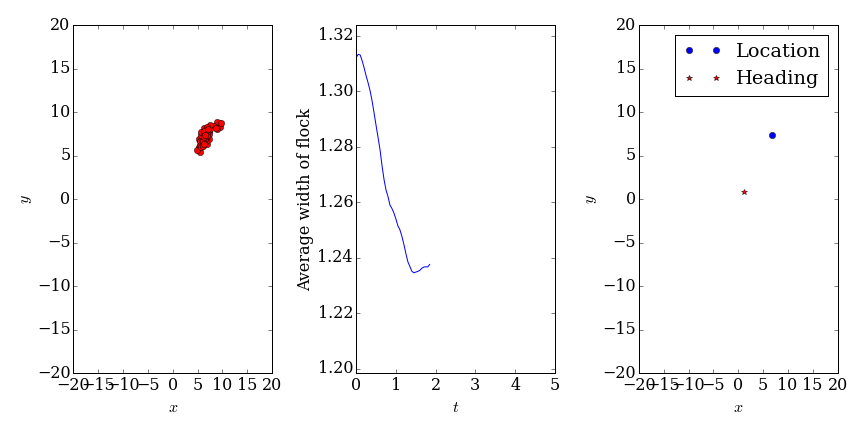
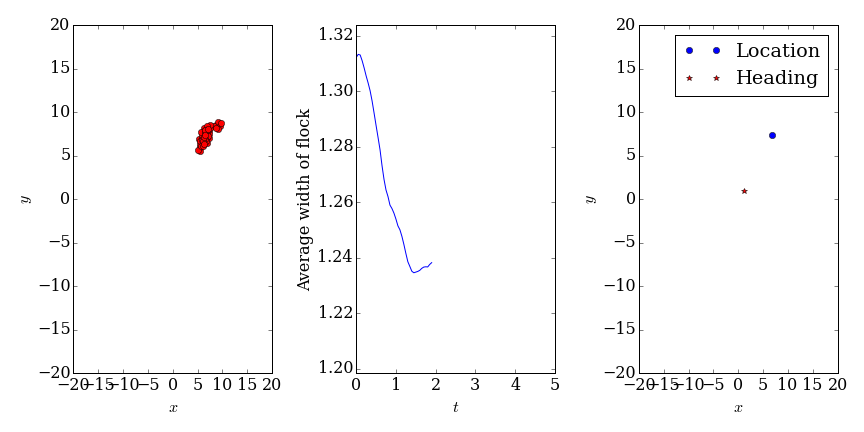
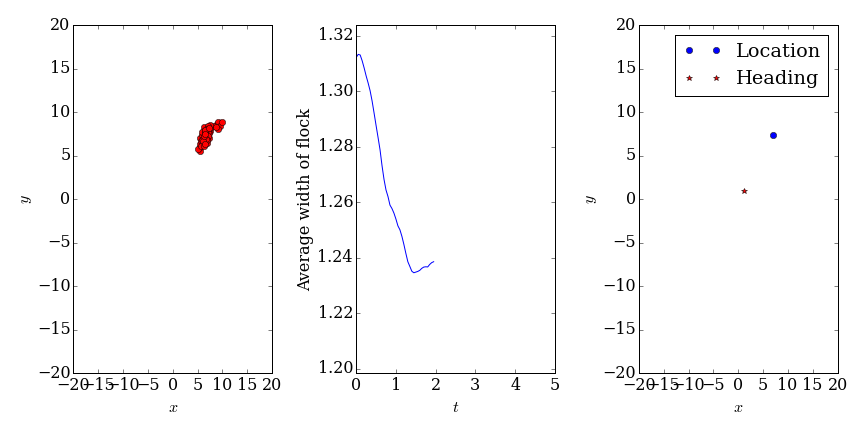
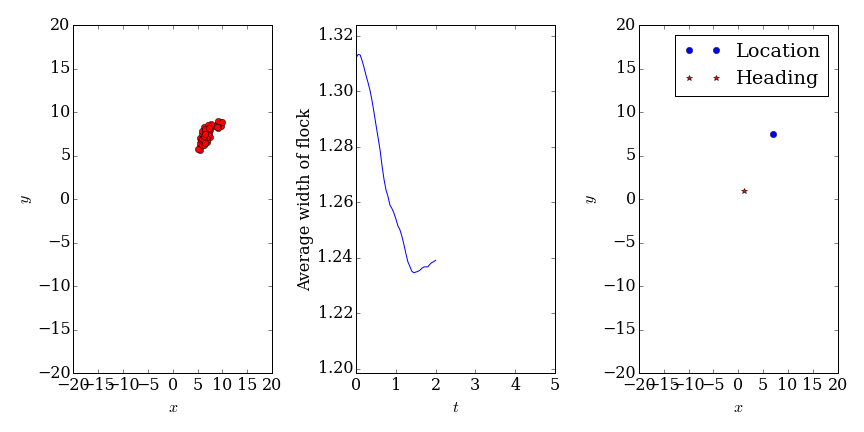
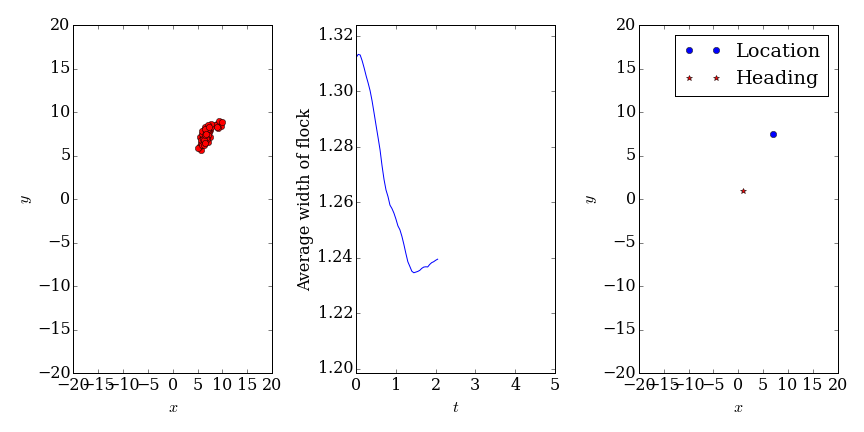
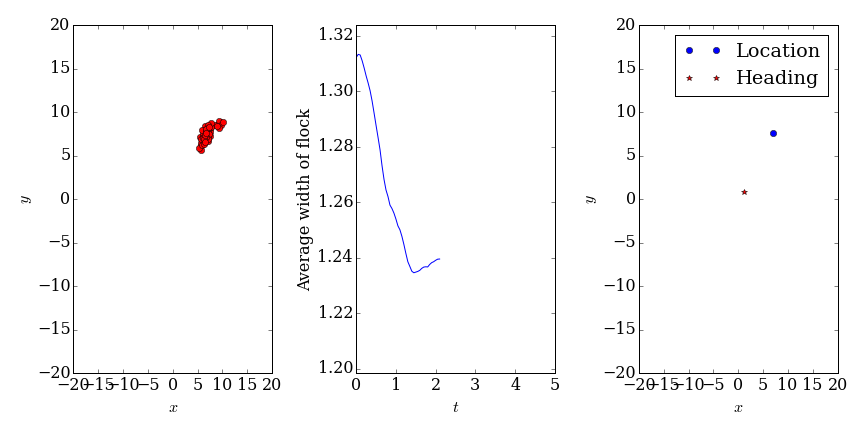
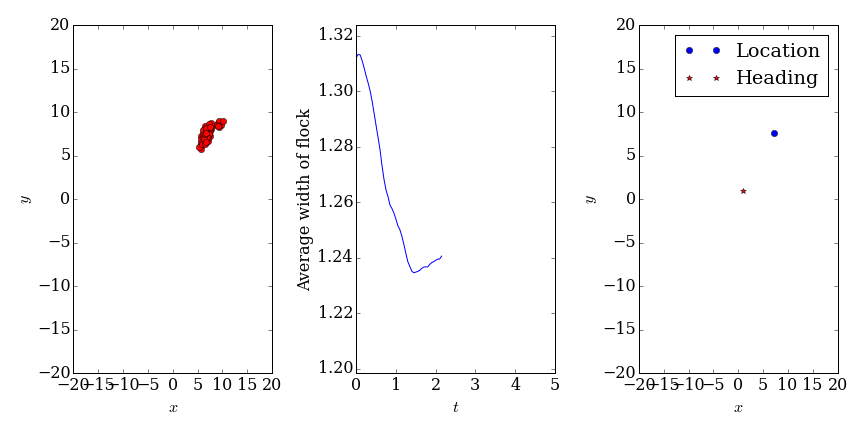
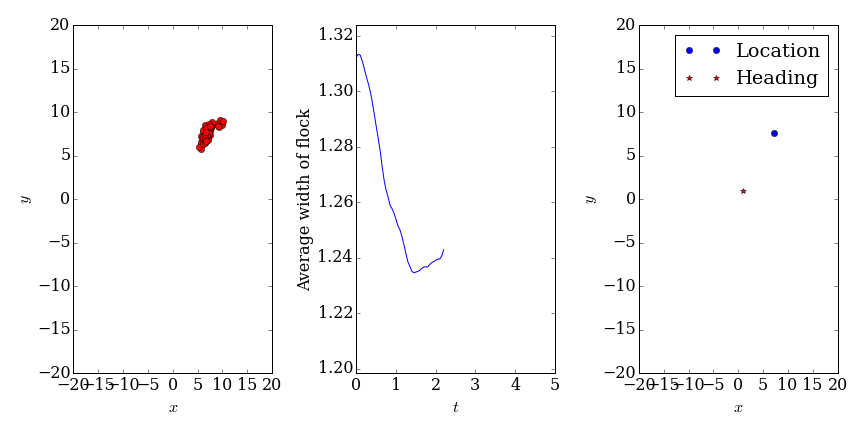
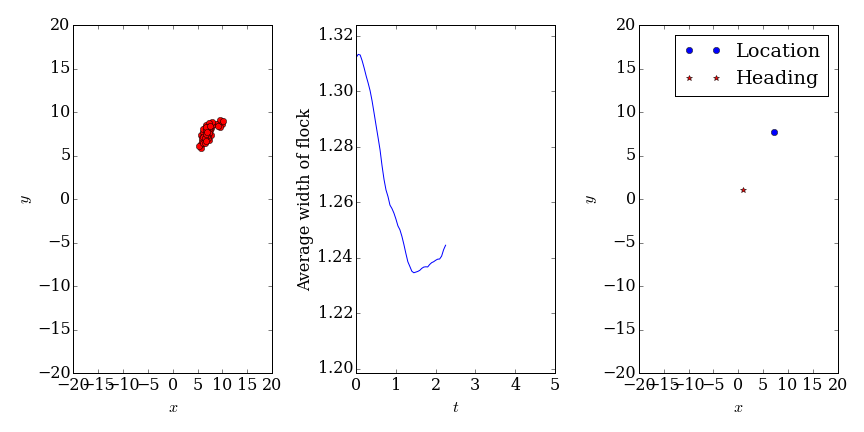
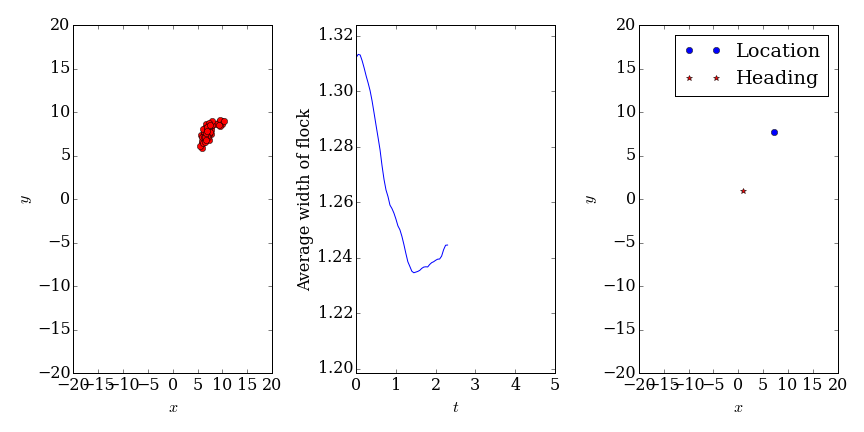
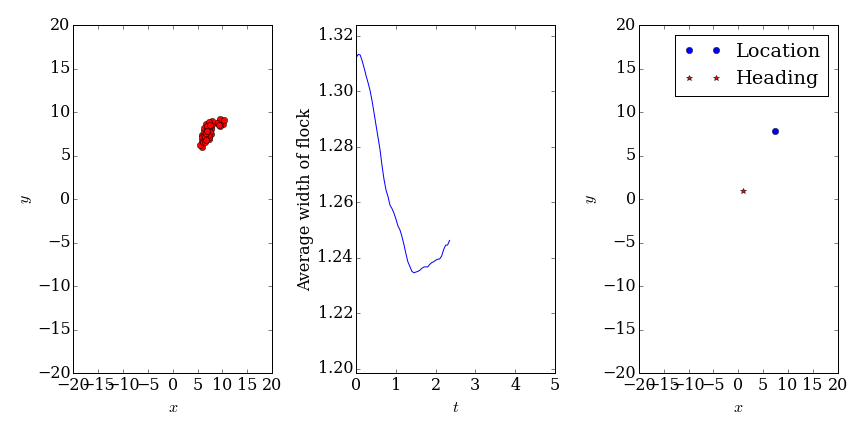
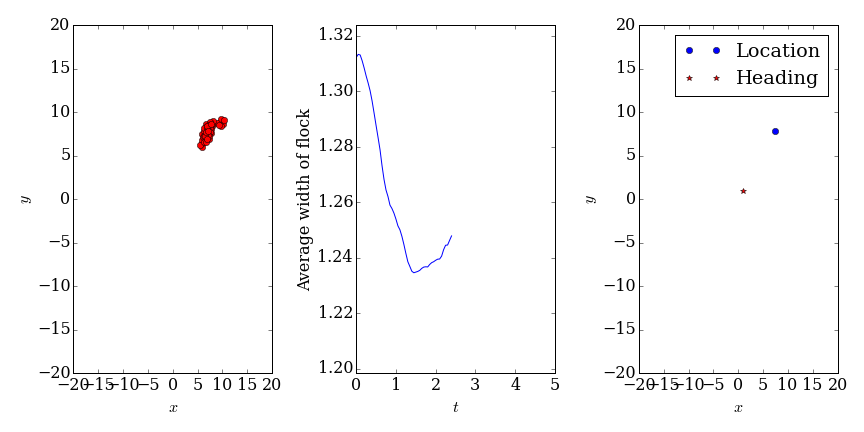
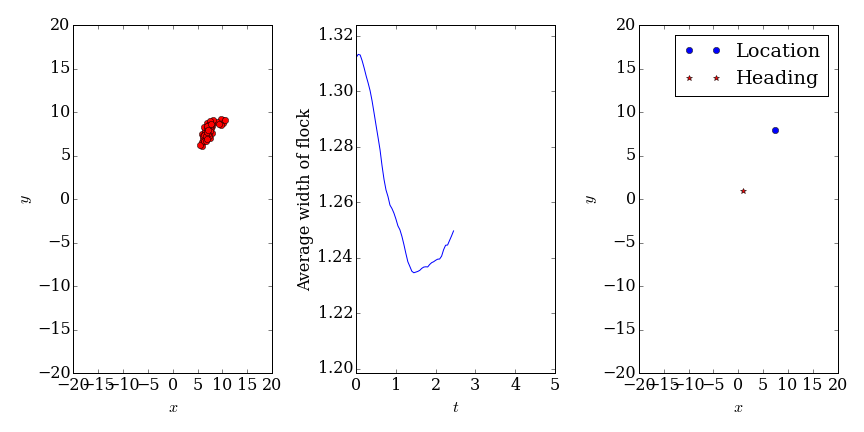
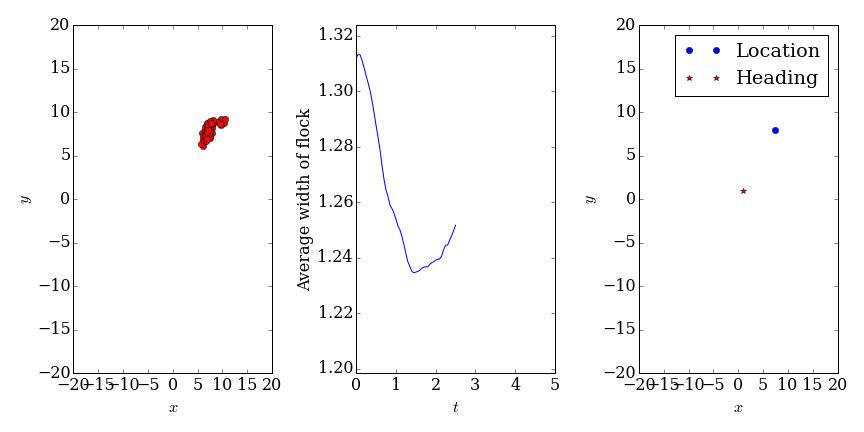
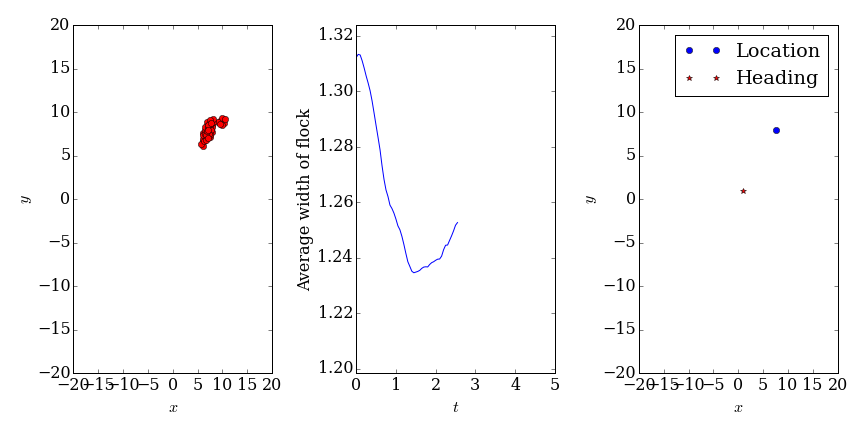
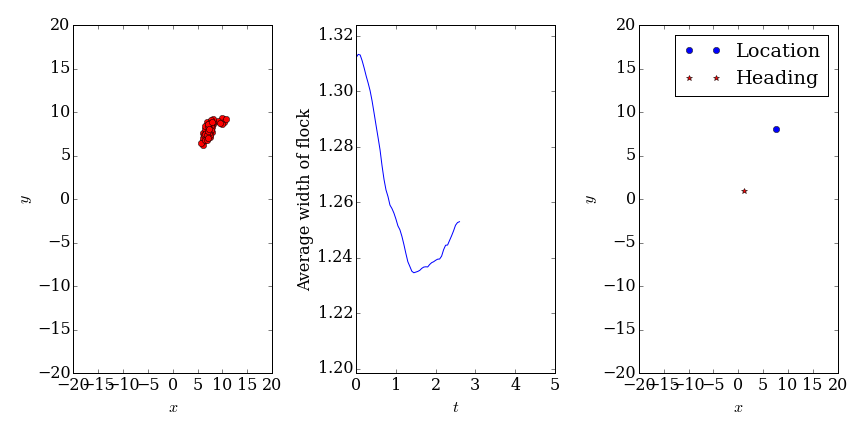
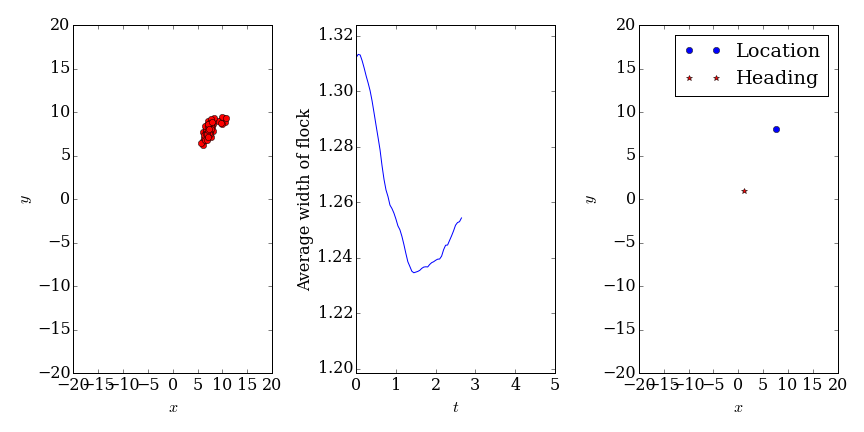
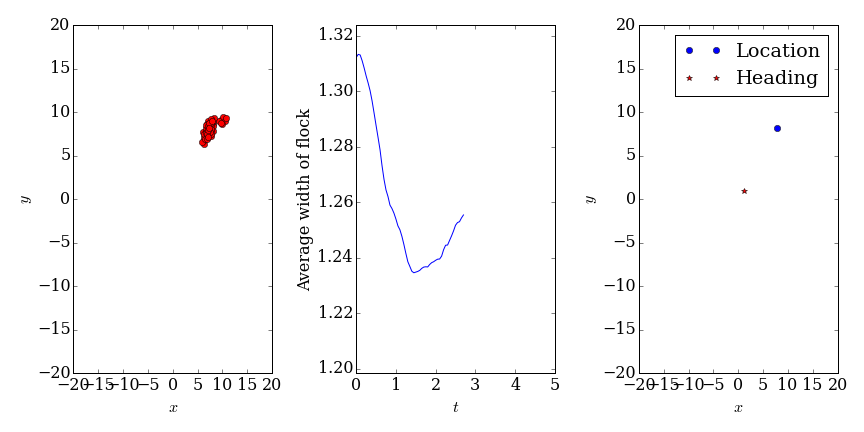
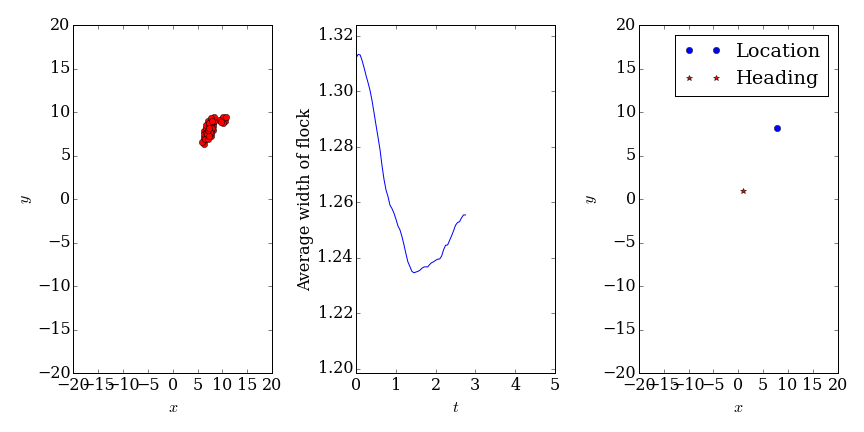
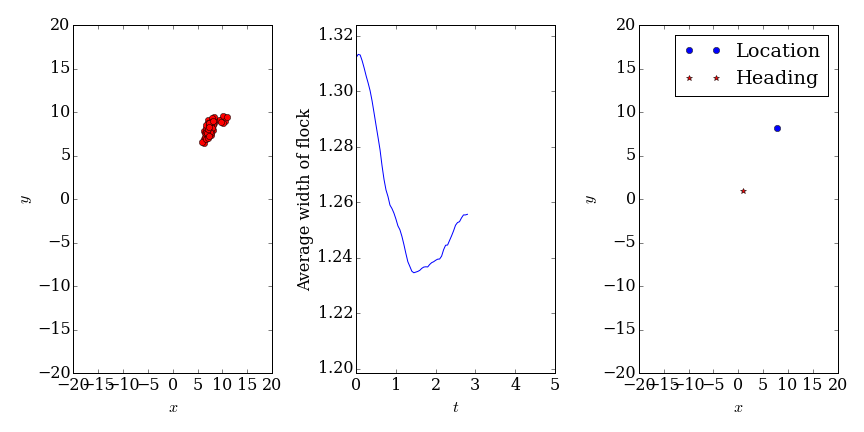
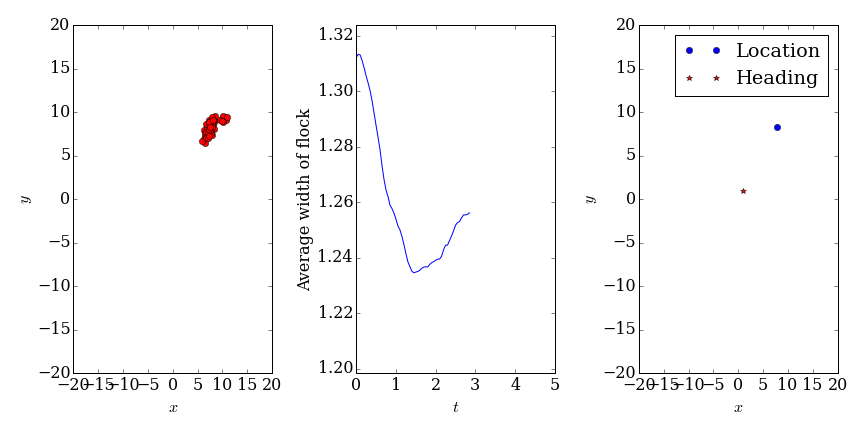
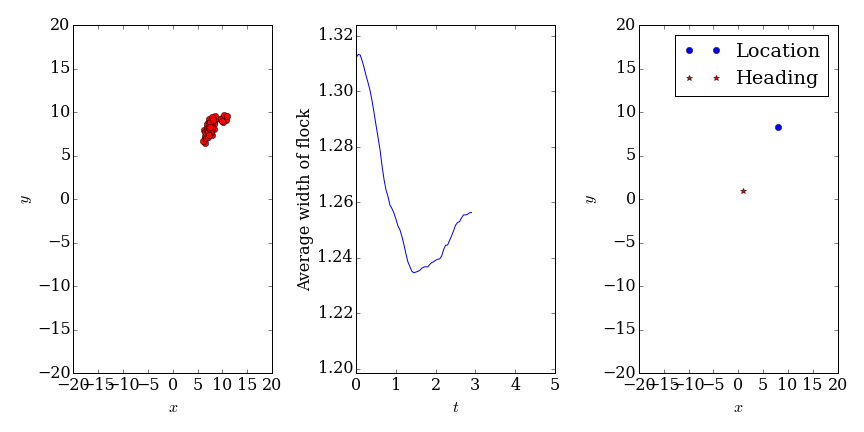
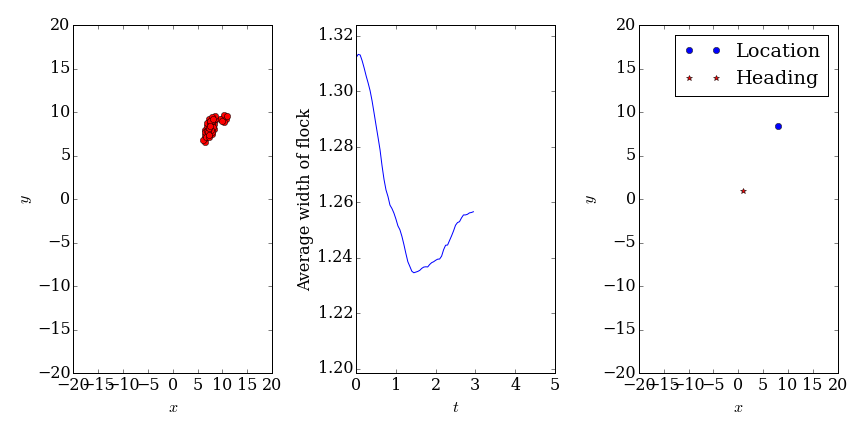
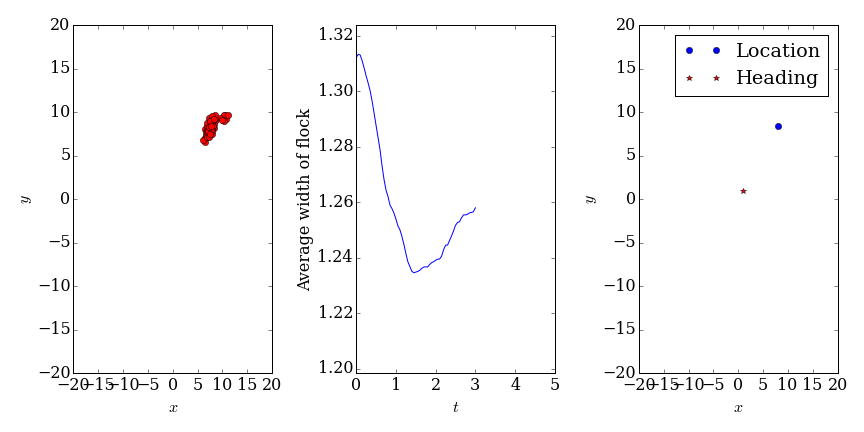
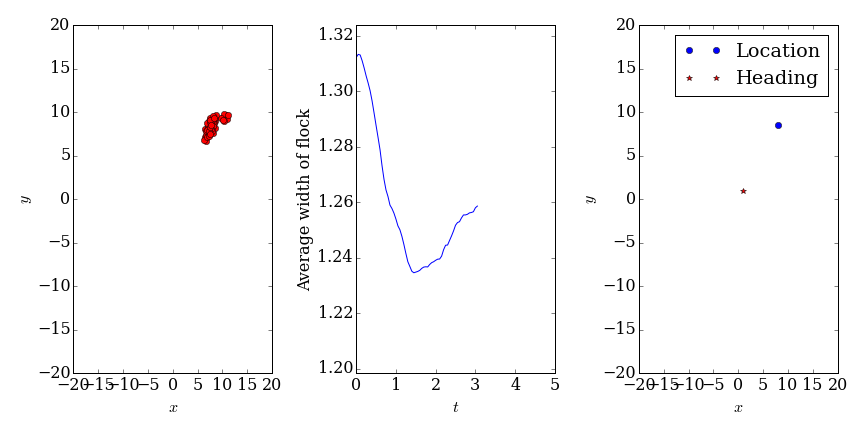
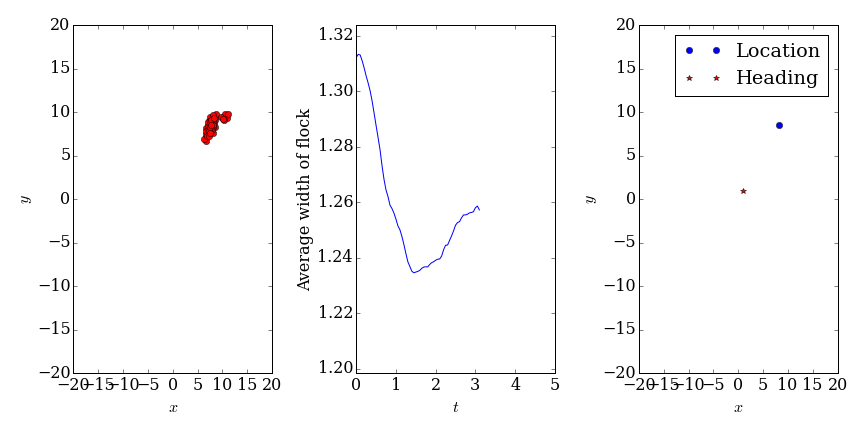
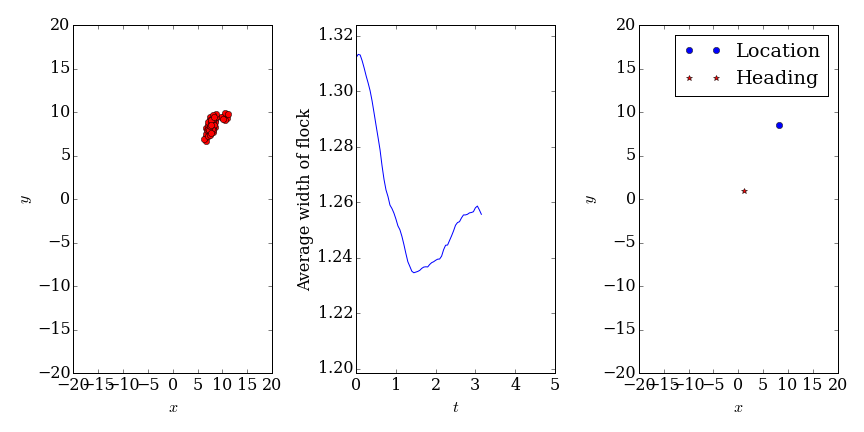
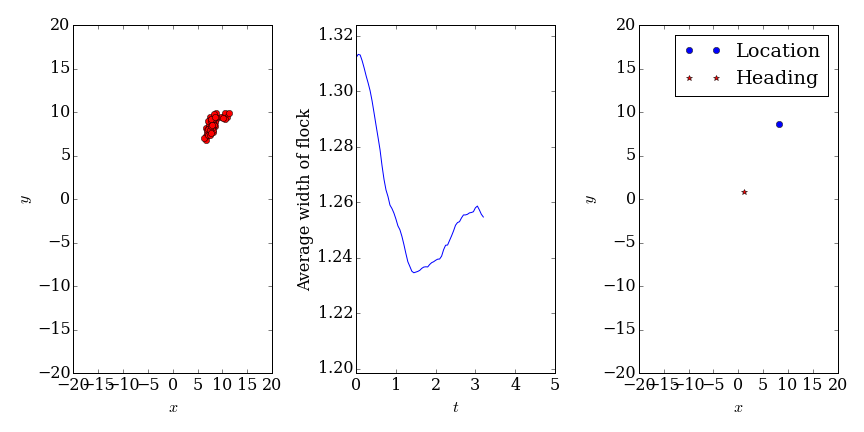
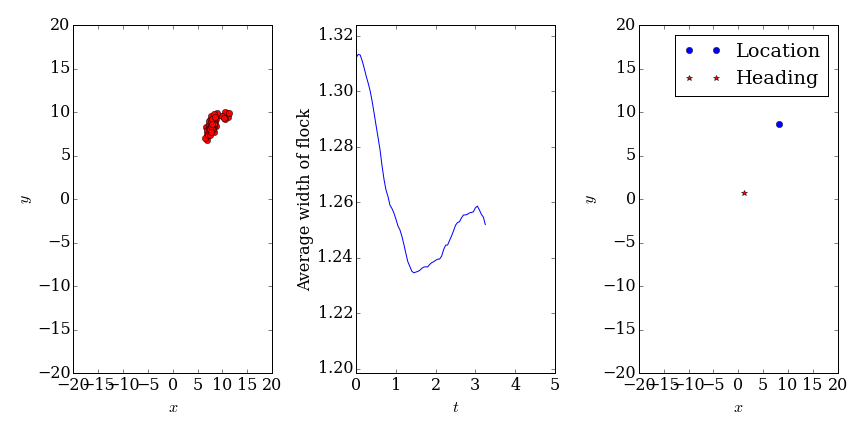
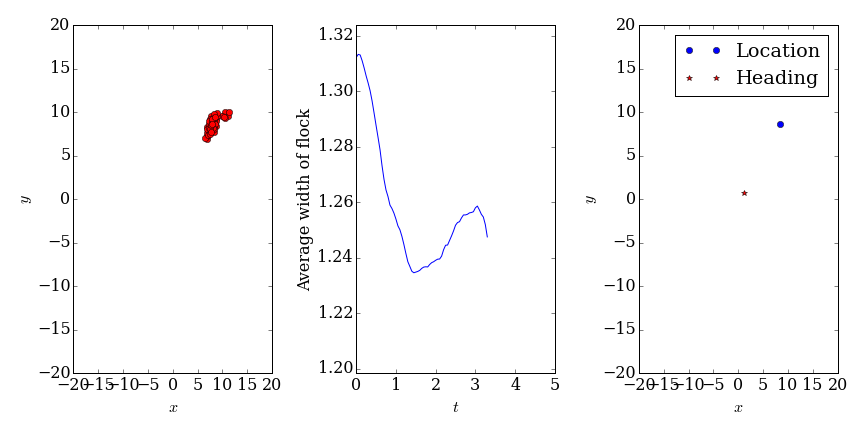
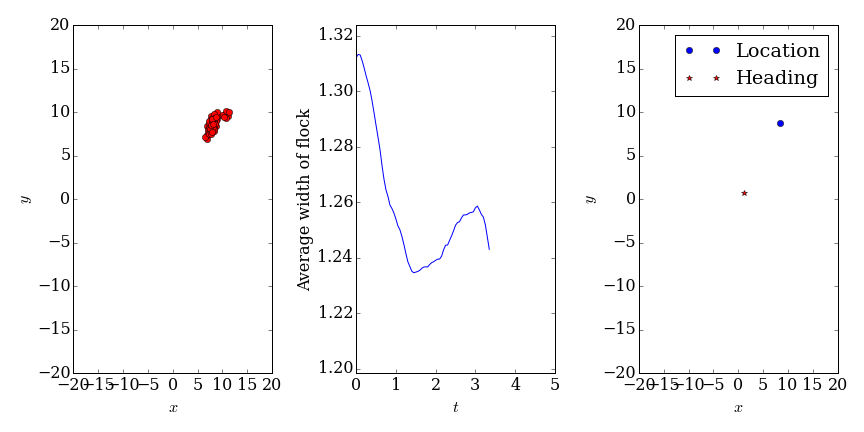
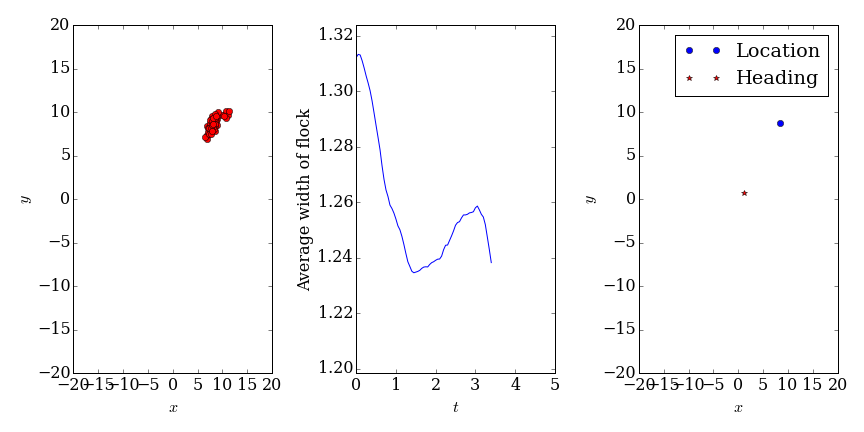
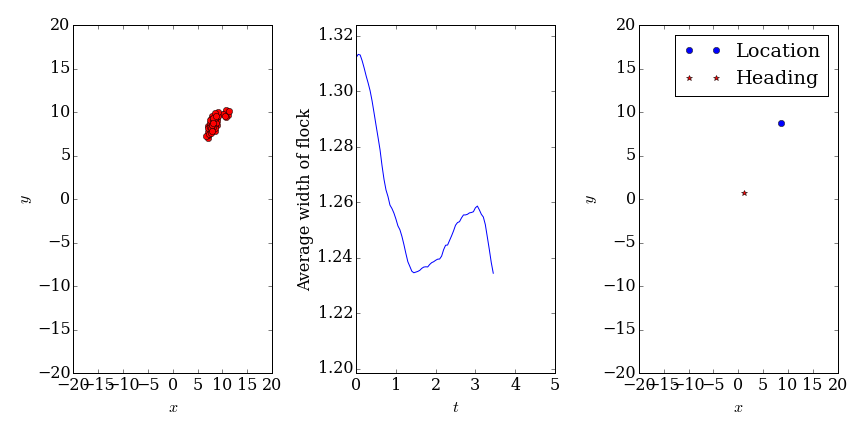
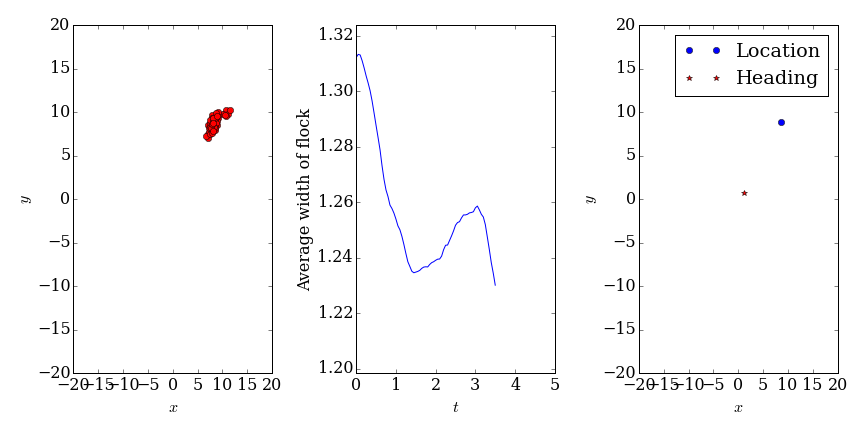
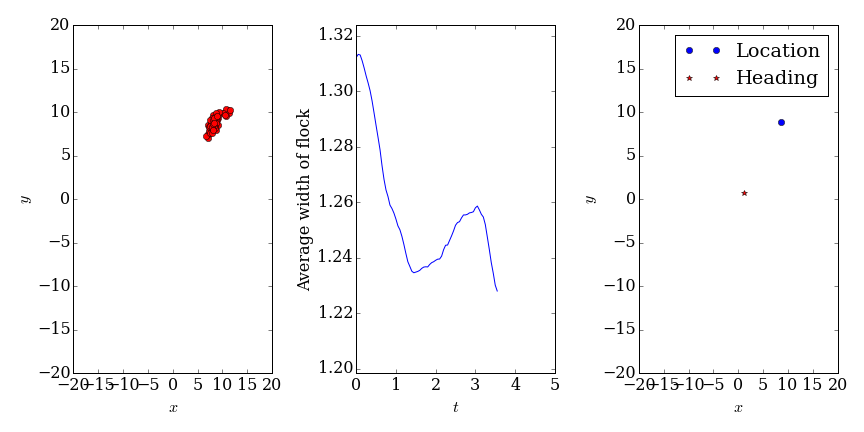
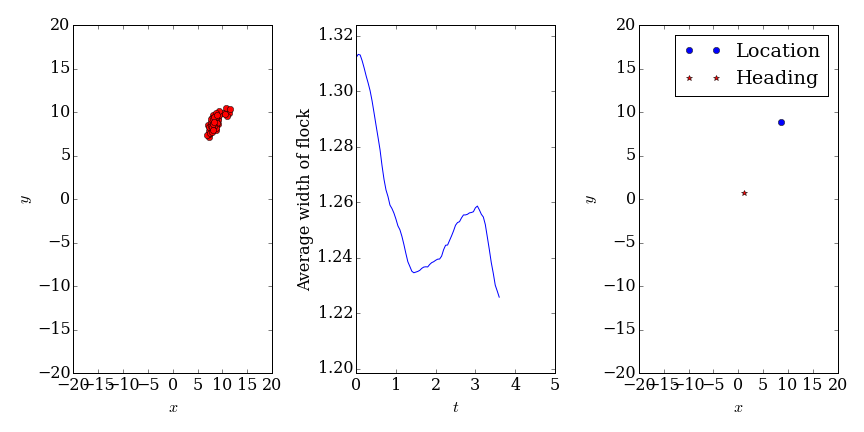
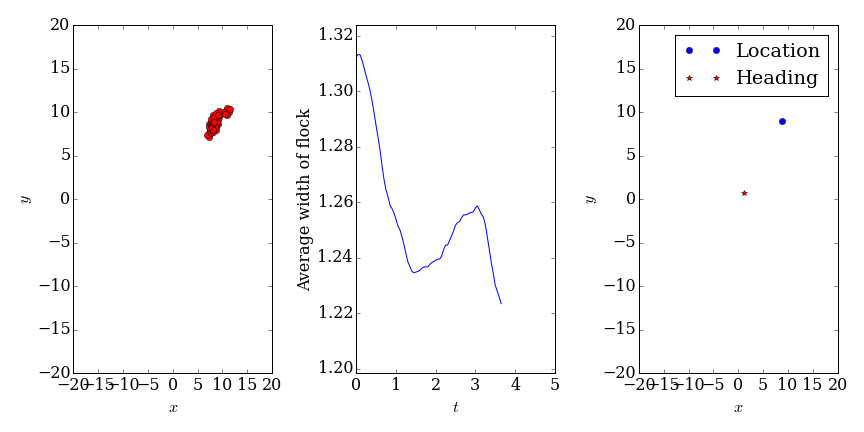
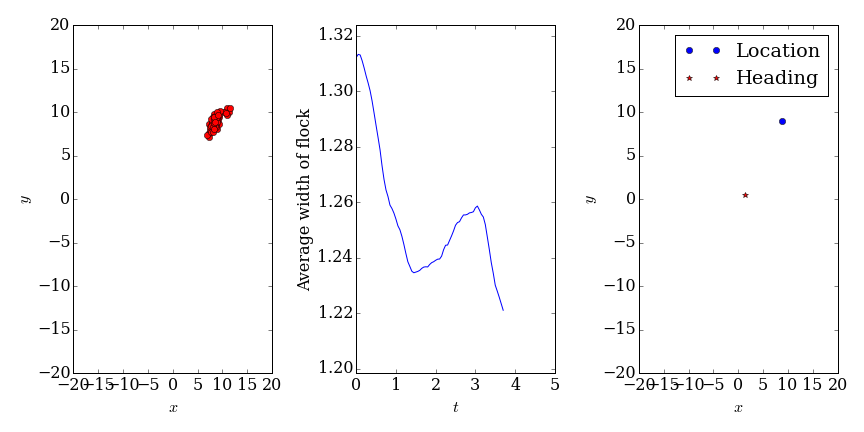
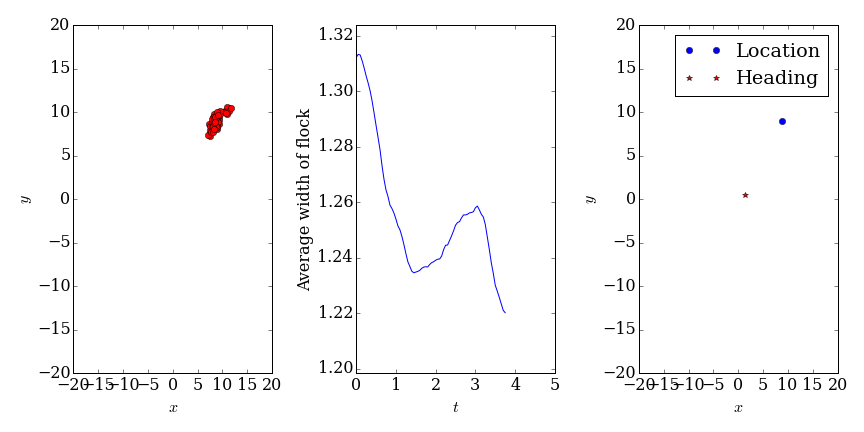
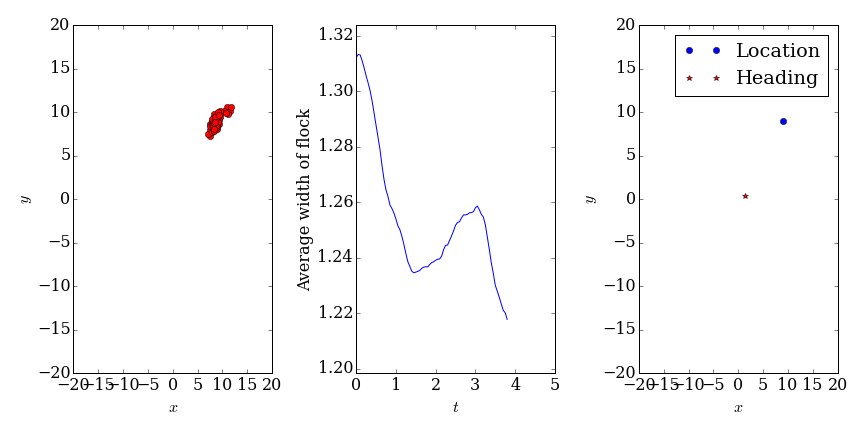
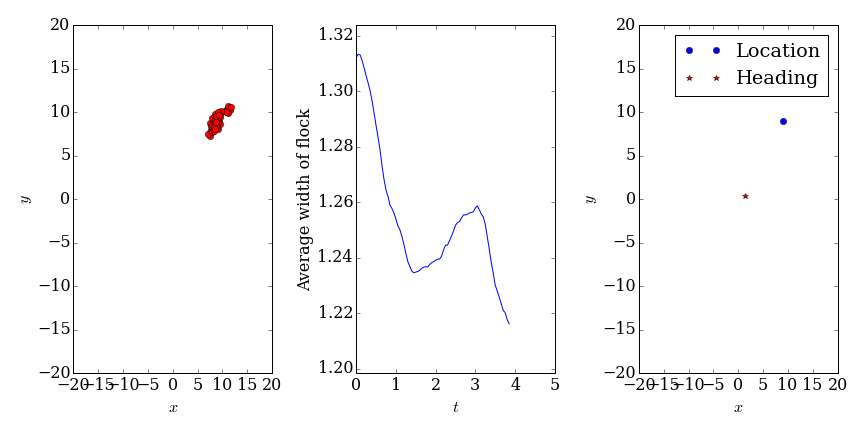
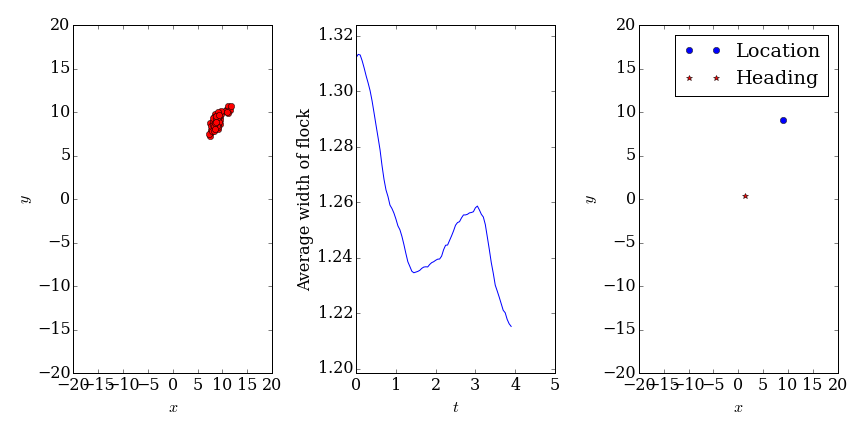
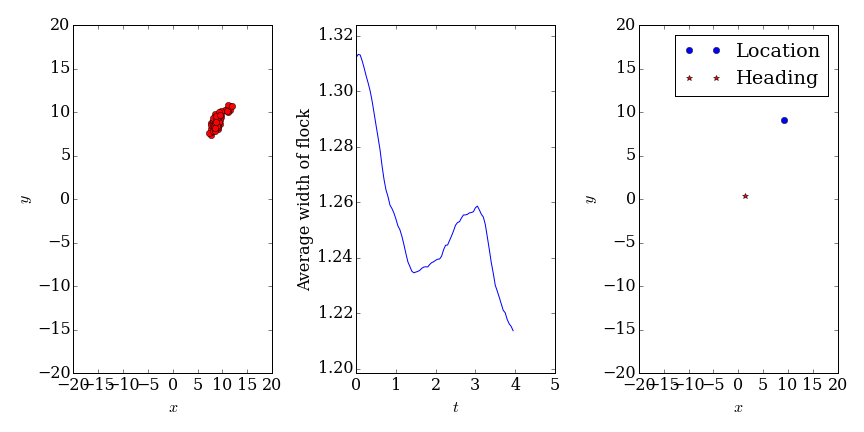
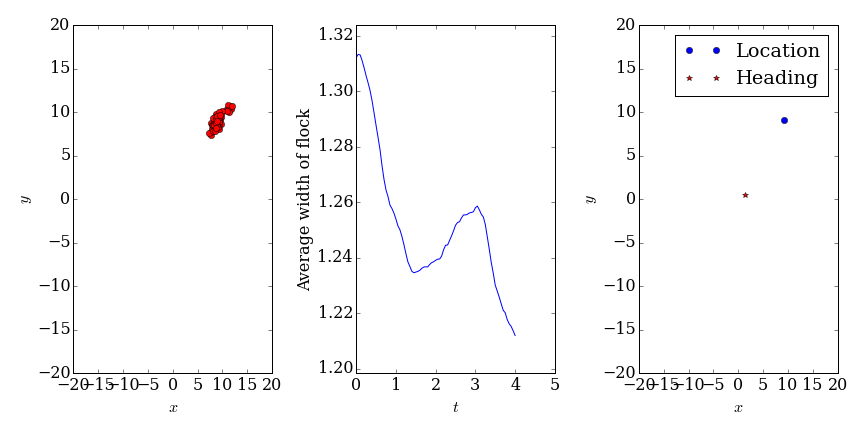
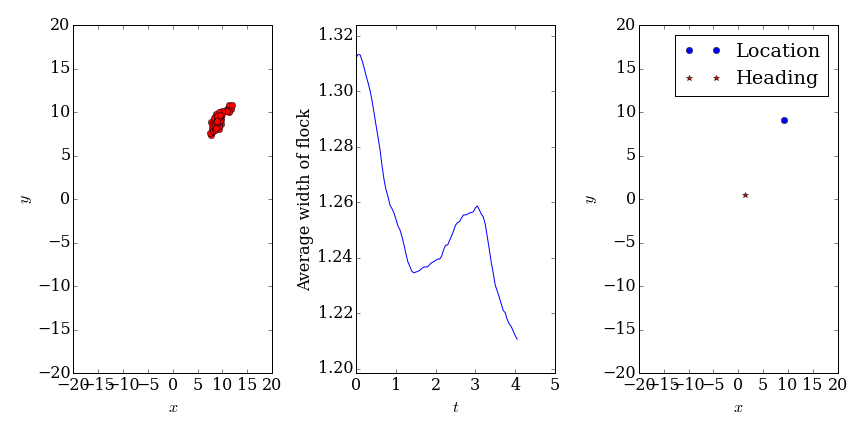
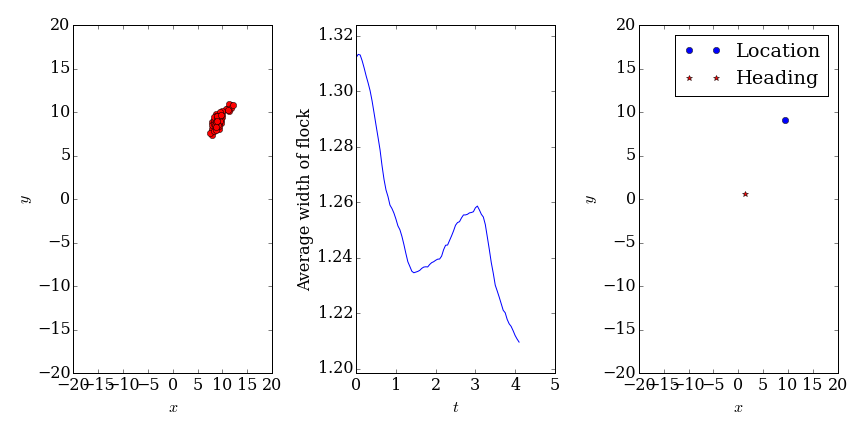
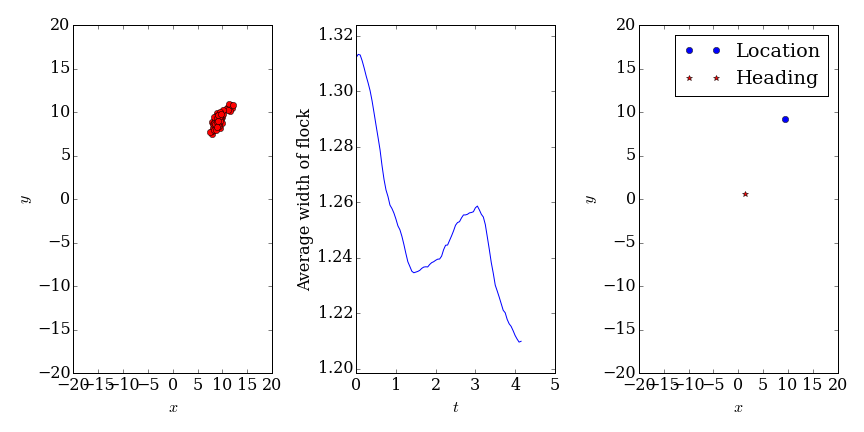
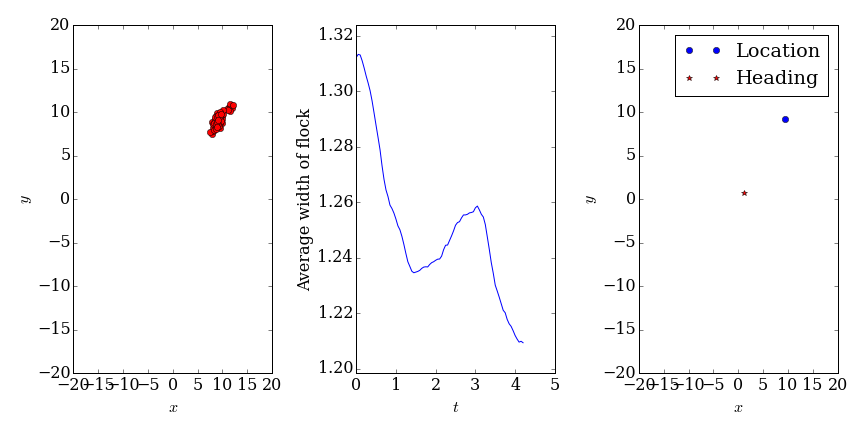
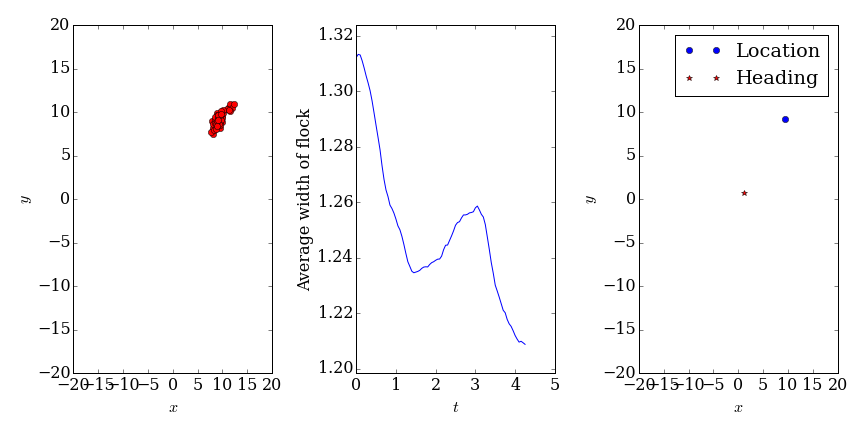
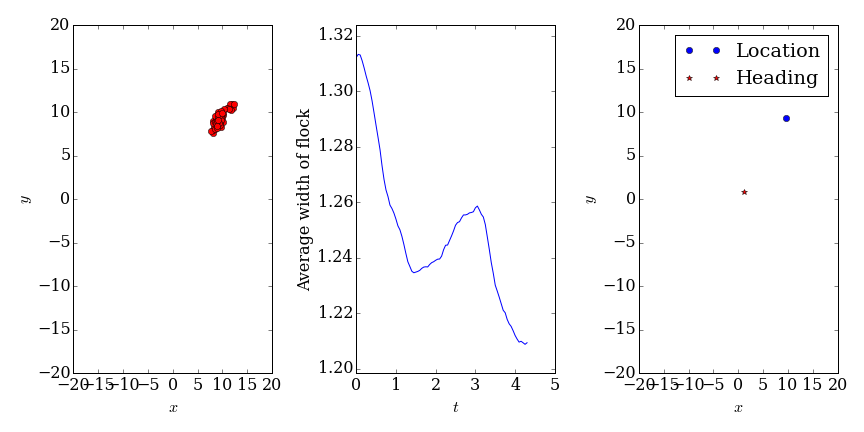
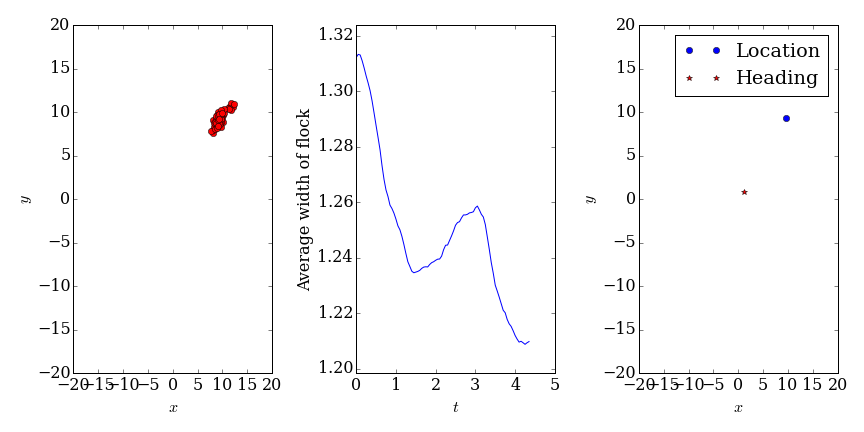
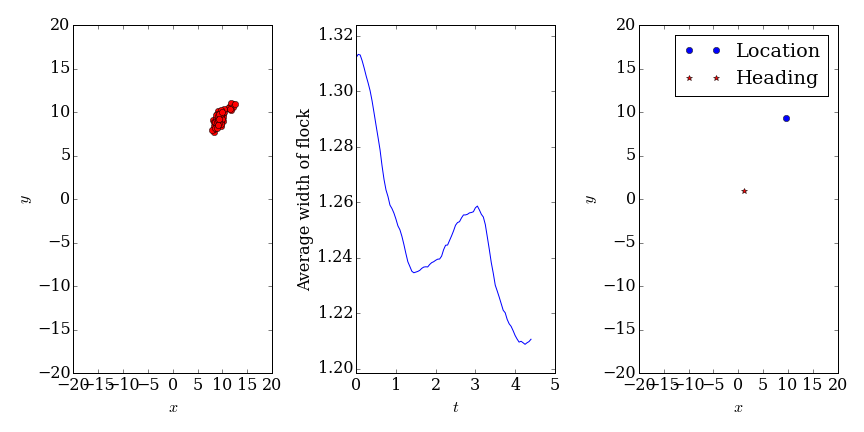
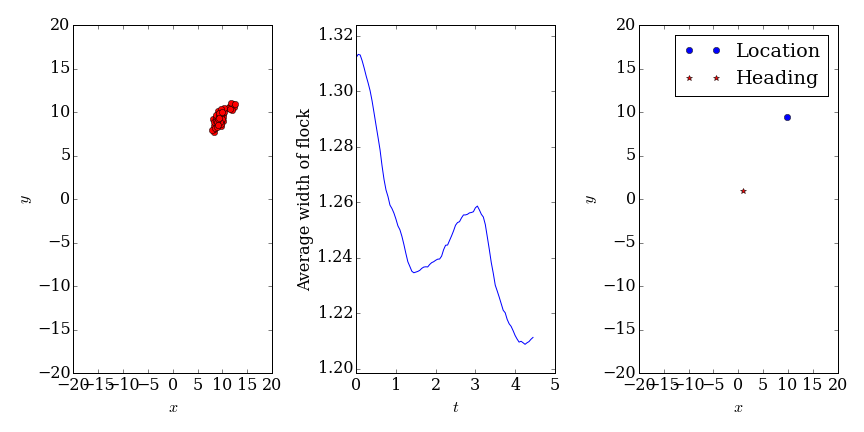
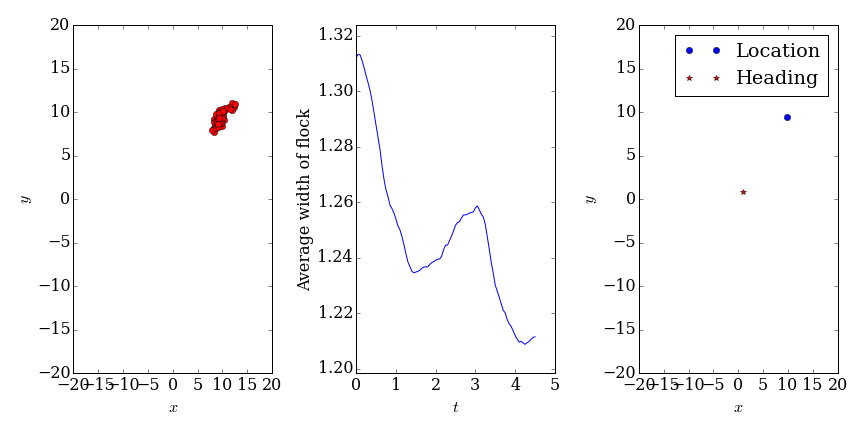
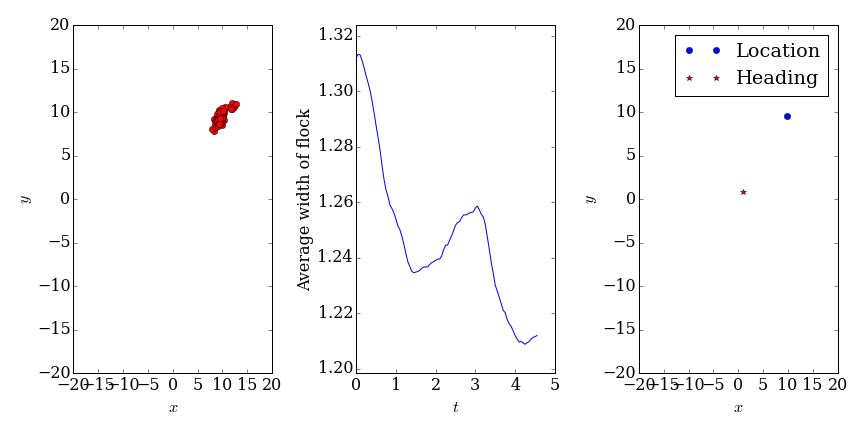
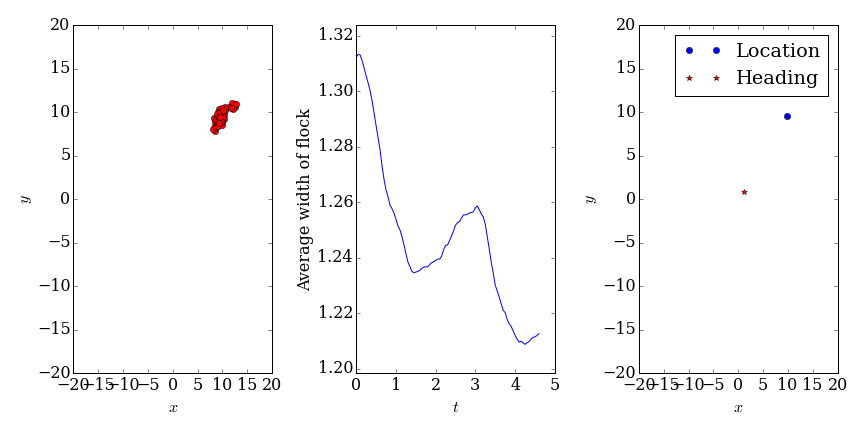
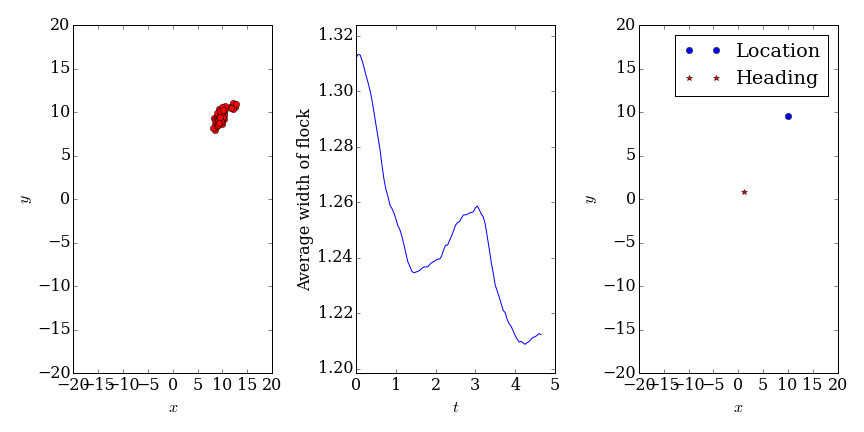
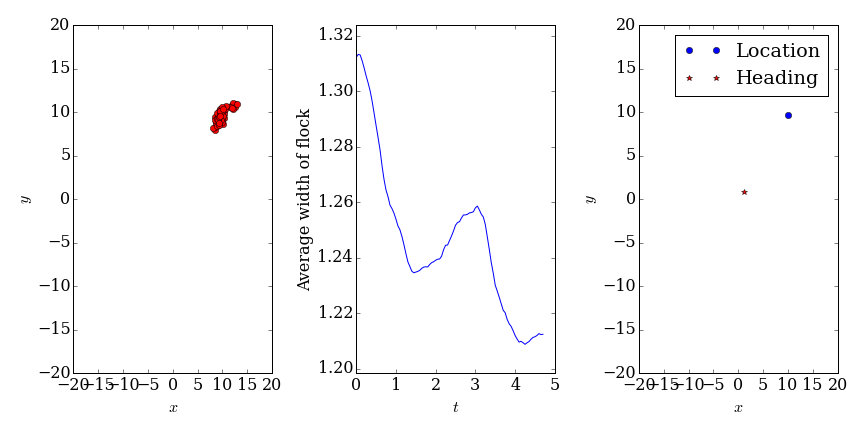
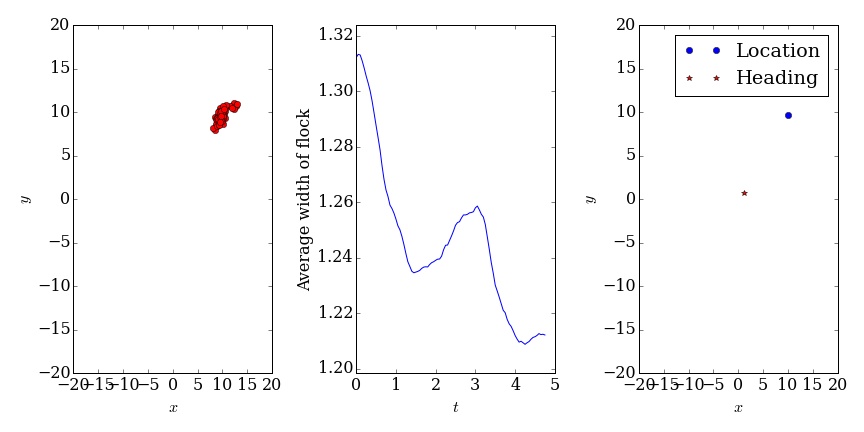
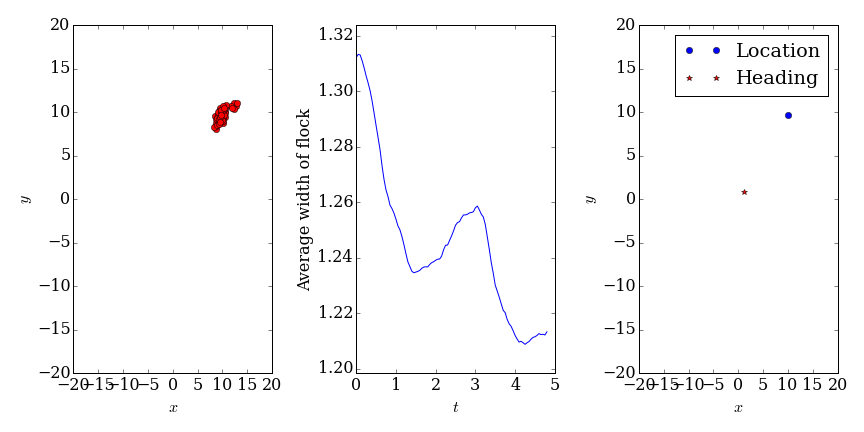
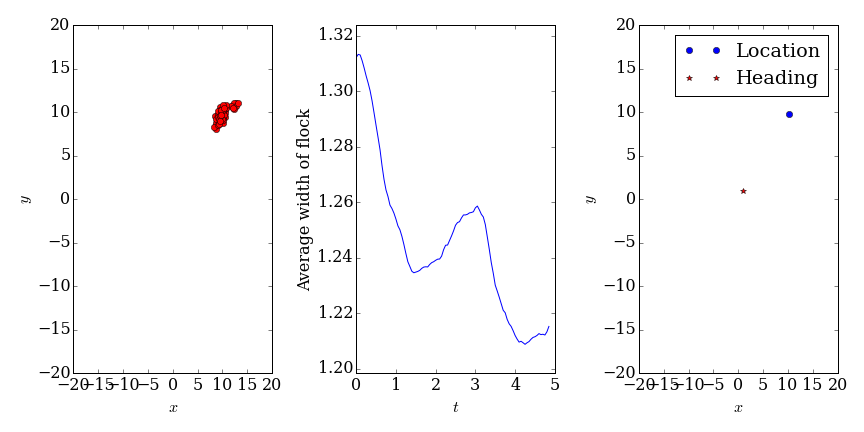
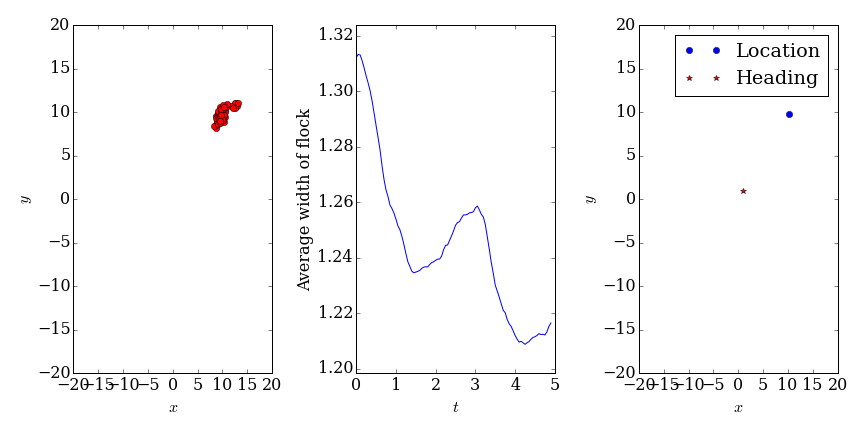
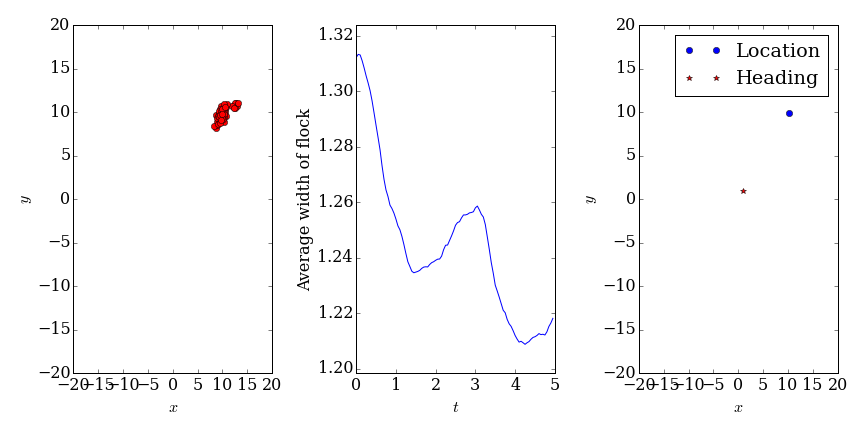

In [12]:
flock_animation(flock, 0.05, 100, xlim=(-20.0,20.0), ylim=(-20.0,20))